In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import v2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 350
LR = 5e-5
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_3"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.5 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/
TRAIN_FRACTION = 0.2

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_3/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_3/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_3/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34*TRAIN_FRACTION, 1-0.34*TRAIN_FRACTION])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34*TRAIN_FRACTION, 1-0.34*TRAIN_FRACTION])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

print(f'This configuration will load {(len(train_dataset)+len(val_dataset))//BATCH_SIZE} (low-resolution) images in total, with an 80:20 validation split.') 

This configuration will load 204 (low-resolution) images in total, with an 80:20 validation split.


### Defining data-augmentations

In [5]:
transforms = v2.Compose([
    v2.RandomRotation(degrees=(-180,180)),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5)
])

### Model and physics-inspired loss function loading

In [6]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}")

Image network parameters: 900422


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [7]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [8]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

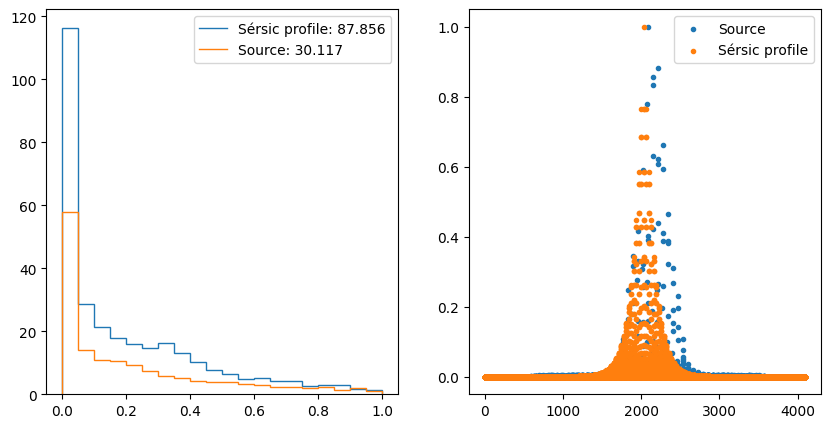

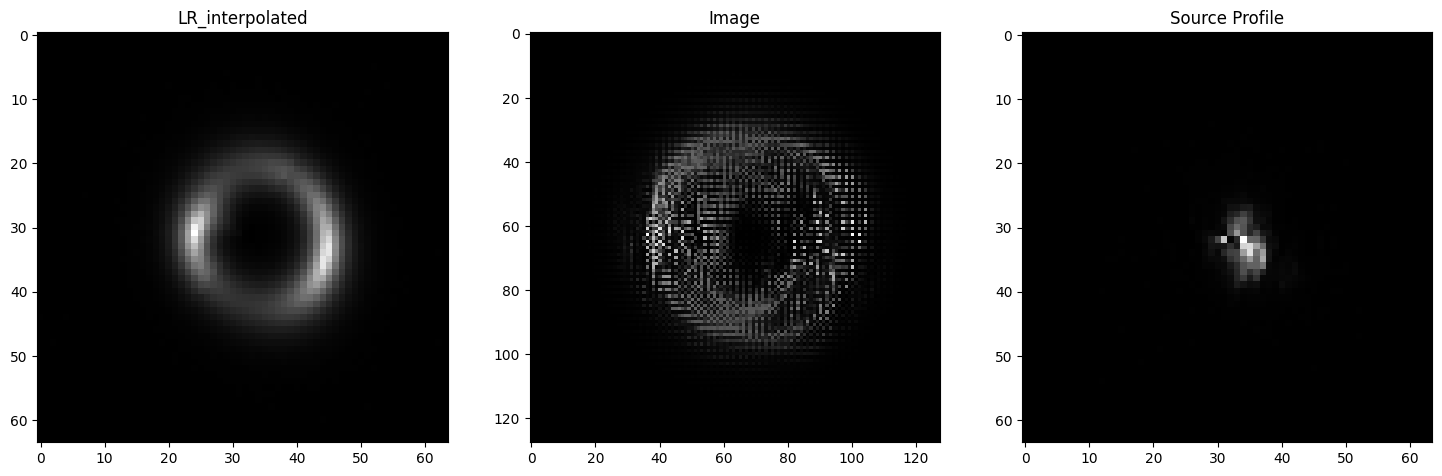

In [9]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [10]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    alpha_model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = transforms((x.float().to(device)))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = transforms((x.float().to(device)))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual = lens_loss(alpha, x)
        losses.append(float(val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses) and np.mean(losses) != np.nan:
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 164/164 [00:08<00:00, 19.13it/s]


Training at epoch 1/350: 0.02236287910264076 at LR=5e-05


Validation epoch 1: 100%|██████████| 41/41 [00:01<00:00, 26.67it/s]


Validation at epoch 1/350: 0.023139408903151026 at LR=5e-05


Training epoch 2: 100%|██████████| 164/164 [00:08<00:00, 19.46it/s]


Training at epoch 2/350: 0.022850841931180983 at LR=5e-05


Validation epoch 2: 100%|██████████| 41/41 [00:01<00:00, 26.77it/s]


Validation at epoch 2/350: 0.023407524269891948 at LR=5e-05


Training epoch 3: 100%|██████████| 164/164 [00:08<00:00, 19.46it/s]


Training at epoch 3/350: 0.022304619196802378 at LR=5e-05


Validation epoch 3: 100%|██████████| 41/41 [00:01<00:00, 26.47it/s]


Validation at epoch 3/350: 0.022116562351584435 at LR=5e-05


Training epoch 4: 100%|██████████| 164/164 [00:08<00:00, 19.40it/s]


Training at epoch 4/350: 0.02193282963708043 at LR=5e-05


Validation epoch 4: 100%|██████████| 41/41 [00:01<00:00, 27.14it/s]


Validation at epoch 4/350: 0.022049116470464848 at LR=5e-05


Training epoch 5: 100%|██████████| 164/164 [00:08<00:00, 19.24it/s]


Training at epoch 5/350: 0.021793163898287386 at LR=5e-05


Validation epoch 5: 100%|██████████| 41/41 [00:01<00:00, 27.57it/s]


Validation at epoch 5/350: 0.02201273437680268 at LR=5e-05


Training epoch 6: 100%|██████████| 164/164 [00:08<00:00, 19.02it/s]


Training at epoch 6/350: 0.021544215479502225 at LR=5e-05


Validation epoch 6: 100%|██████████| 41/41 [00:01<00:00, 27.09it/s]


Validation at epoch 6/350: 0.02063885322067796 at LR=5e-05


Training epoch 7: 100%|██████████| 164/164 [00:08<00:00, 19.15it/s]


Training at epoch 7/350: 0.02079941627637642 at LR=5e-05


Validation epoch 7: 100%|██████████| 41/41 [00:01<00:00, 27.96it/s]


Validation at epoch 7/350: 0.020951106099457276 at LR=5e-05


Training epoch 8: 100%|██████████| 164/164 [00:08<00:00, 19.41it/s]


Training at epoch 8/350: 0.020026181534886722 at LR=5e-05


Validation epoch 8: 100%|██████████| 41/41 [00:01<00:00, 27.36it/s]


Validation at epoch 8/350: 0.01939730014561153 at LR=5e-05


Training epoch 9: 100%|██████████| 164/164 [00:08<00:00, 19.33it/s]


Training at epoch 9/350: 0.019478504421053137 at LR=5e-05


Validation epoch 9: 100%|██████████| 41/41 [00:01<00:00, 27.12it/s]


Validation at epoch 9/350: 0.01868470285723849 at LR=5e-05


Training epoch 10: 100%|██████████| 164/164 [00:08<00:00, 19.29it/s]


Training at epoch 10/350: 0.01732413026095345 at LR=5e-05


Validation epoch 10: 100%|██████████| 41/41 [00:01<00:00, 27.94it/s]


Validation at epoch 10/350: 0.014907230804787903 at LR=5e-05


Training epoch 11: 100%|██████████| 164/164 [00:08<00:00, 19.40it/s]


Training at epoch 11/350: 0.014514038316542053 at LR=5e-05


Validation epoch 11: 100%|██████████| 41/41 [00:01<00:00, 26.93it/s]


Validation at epoch 11/350: 0.01378580248664792 at LR=5e-05


Training epoch 12: 100%|██████████| 164/164 [00:08<00:00, 18.97it/s]


Training at epoch 12/350: 0.012878920699799115 at LR=5e-05


Validation epoch 12: 100%|██████████| 41/41 [00:01<00:00, 26.26it/s]


Validation at epoch 12/350: 0.014256855711431765 at LR=5e-05


Training epoch 13: 100%|██████████| 164/164 [00:08<00:00, 19.03it/s]


Training at epoch 13/350: 0.013032756260278203 at LR=5e-05


Validation epoch 13: 100%|██████████| 41/41 [00:01<00:00, 27.30it/s]


Validation at epoch 13/350: 0.013373514739569369 at LR=5e-05


Training epoch 14: 100%|██████████| 164/164 [00:08<00:00, 18.89it/s]


Training at epoch 14/350: 0.012348999167088329 at LR=5e-05


Validation epoch 14: 100%|██████████| 41/41 [00:01<00:00, 24.62it/s]


Validation at epoch 14/350: 0.012413976748087783 at LR=5e-05


Training epoch 15: 100%|██████████| 164/164 [00:08<00:00, 19.19it/s]


Training at epoch 15/350: 0.012230920542894706 at LR=5e-05


Validation epoch 15: 100%|██████████| 41/41 [00:01<00:00, 28.37it/s]


Validation at epoch 15/350: 0.011608378007644561 at LR=5e-05


Training epoch 16: 100%|██████████| 164/164 [00:08<00:00, 19.61it/s]


Training at epoch 16/350: 0.01213641970407036 at LR=5e-05


Validation epoch 16: 100%|██████████| 41/41 [00:01<00:00, 26.80it/s]


Validation at epoch 16/350: 0.012744423967399976 at LR=5e-05


Training epoch 17: 100%|██████████| 164/164 [00:08<00:00, 19.54it/s]


Training at epoch 17/350: 0.012425734540845107 at LR=5e-05


Validation epoch 17: 100%|██████████| 41/41 [00:01<00:00, 28.52it/s]


Validation at epoch 17/350: 0.01129954073169246 at LR=5e-05


Training epoch 18: 100%|██████████| 164/164 [00:08<00:00, 19.29it/s]


Training at epoch 18/350: 0.011588779102056853 at LR=5e-05


Validation epoch 18: 100%|██████████| 41/41 [00:01<00:00, 29.37it/s]


Validation at epoch 18/350: 0.013053159036378307 at LR=5e-05


Training epoch 19: 100%|██████████| 164/164 [00:08<00:00, 19.02it/s]


Training at epoch 19/350: 0.011904469571962225 at LR=5e-05


Validation epoch 19: 100%|██████████| 41/41 [00:01<00:00, 26.71it/s]


Validation at epoch 19/350: 0.012311215643066824 at LR=5e-05


Training epoch 20: 100%|██████████| 164/164 [00:08<00:00, 19.18it/s]


Training at epoch 20/350: 0.011772655387886051 at LR=5e-05


Validation epoch 20: 100%|██████████| 41/41 [00:01<00:00, 28.51it/s]


Validation at epoch 20/350: 0.012436873682706458 at LR=5e-05


Training epoch 21: 100%|██████████| 164/164 [00:08<00:00, 19.56it/s]


Training at epoch 21/350: 0.011561602796995784 at LR=5e-05


Validation epoch 21: 100%|██████████| 41/41 [00:01<00:00, 27.14it/s]


Validation at epoch 21/350: 0.011788646389571271 at LR=5e-05


Training epoch 22: 100%|██████████| 164/164 [00:08<00:00, 19.47it/s]


Training at epoch 22/350: 0.011539657338999393 at LR=5e-05


Validation epoch 22: 100%|██████████| 41/41 [00:01<00:00, 28.47it/s]


Validation at epoch 22/350: 0.011832560162718702 at LR=5e-05


Training epoch 23: 100%|██████████| 164/164 [00:08<00:00, 19.53it/s]


Training at epoch 23/350: 0.011354936211563013 at LR=5e-05


Validation epoch 23: 100%|██████████| 41/41 [00:01<00:00, 28.02it/s]


Validation at epoch 23/350: 0.011732357508707337 at LR=5e-05


Training epoch 24: 100%|██████████| 164/164 [00:08<00:00, 19.19it/s]


Training at epoch 24/350: 0.011421943553325879 at LR=5e-05


Validation epoch 24: 100%|██████████| 41/41 [00:01<00:00, 29.04it/s]


Validation at epoch 24/350: 0.01210660157475348 at LR=5e-05


Training epoch 25: 100%|██████████| 164/164 [00:08<00:00, 19.08it/s]


Training at epoch 25/350: 0.0112405366366502 at LR=5e-05


Validation epoch 25: 100%|██████████| 41/41 [00:01<00:00, 27.67it/s]


Validation at epoch 25/350: 0.010904061170749185 at LR=5e-05


Training epoch 26: 100%|██████████| 164/164 [00:08<00:00, 19.64it/s]


Training at epoch 26/350: 0.01147287590258823 at LR=5e-05


Validation epoch 26: 100%|██████████| 41/41 [00:01<00:00, 27.75it/s]


Validation at epoch 26/350: 0.012072944786490465 at LR=5e-05


Training epoch 27: 100%|██████████| 164/164 [00:08<00:00, 19.10it/s]


Training at epoch 27/350: 0.011324447653506224 at LR=5e-05


Validation epoch 27: 100%|██████████| 41/41 [00:01<00:00, 27.49it/s]


Validation at epoch 27/350: 0.011322122197825371 at LR=5e-05


Training epoch 28: 100%|██████████| 164/164 [00:08<00:00, 19.81it/s]


Training at epoch 28/350: 0.01117131314254593 at LR=5e-05


Validation epoch 28: 100%|██████████| 41/41 [00:01<00:00, 28.14it/s]


Validation at epoch 28/350: 0.011199177668725208 at LR=5e-05


Training epoch 29: 100%|██████████| 164/164 [00:08<00:00, 19.33it/s]


Training at epoch 29/350: 0.010694309553733414 at LR=5e-05


Validation epoch 29: 100%|██████████| 41/41 [00:01<00:00, 26.55it/s]


Validation at epoch 29/350: 0.010649590852397788 at LR=5e-05


Training epoch 30: 100%|██████████| 164/164 [00:08<00:00, 18.88it/s]


Training at epoch 30/350: 0.010974373835956723 at LR=5e-05


Validation epoch 30: 100%|██████████| 41/41 [00:01<00:00, 27.45it/s]


Validation at epoch 30/350: 0.011011367851141388 at LR=5e-05


Training epoch 31: 100%|██████████| 164/164 [00:08<00:00, 19.07it/s]


Training at epoch 31/350: 0.011052811437388656 at LR=5e-05


Validation epoch 31: 100%|██████████| 41/41 [00:01<00:00, 27.21it/s]


Validation at epoch 31/350: 0.011372829274921793 at LR=5e-05


Training epoch 32: 100%|██████████| 164/164 [00:08<00:00, 19.03it/s]


Training at epoch 32/350: 0.010902859624787575 at LR=5e-05


Validation epoch 32: 100%|██████████| 41/41 [00:01<00:00, 27.54it/s]


Validation at epoch 32/350: 0.010679572979669746 at LR=5e-05


Training epoch 33: 100%|██████████| 164/164 [00:08<00:00, 18.77it/s]


Training at epoch 33/350: 0.010927734144100146 at LR=5e-05


Validation epoch 33: 100%|██████████| 41/41 [00:01<00:00, 28.17it/s]


Validation at epoch 33/350: 0.010667562496098803 at LR=5e-05


Training epoch 34: 100%|██████████| 164/164 [00:08<00:00, 18.98it/s]


Training at epoch 34/350: 0.010495705829603916 at LR=5e-05


Validation epoch 34: 100%|██████████| 41/41 [00:01<00:00, 26.62it/s]


Validation at epoch 34/350: 0.011109800972385196 at LR=5e-05


Training epoch 35: 100%|██████████| 164/164 [00:08<00:00, 18.72it/s]


Training at epoch 35/350: 0.010475190227181172 at LR=5e-05


Validation epoch 35: 100%|██████████| 41/41 [00:01<00:00, 26.21it/s]


Validation at epoch 35/350: 0.01026290332580485 at LR=5e-05


Training epoch 36: 100%|██████████| 164/164 [00:08<00:00, 19.12it/s]


Training at epoch 36/350: 0.01006936674324296 at LR=5e-05


Validation epoch 36: 100%|██████████| 41/41 [00:01<00:00, 26.85it/s]


Validation at epoch 36/350: 0.010854956313467973 at LR=5e-05


Training epoch 37: 100%|██████████| 164/164 [00:08<00:00, 18.92it/s]


Training at epoch 37/350: 0.011086894843795495 at LR=5e-05


Validation epoch 37: 100%|██████████| 41/41 [00:01<00:00, 26.58it/s]


Validation at epoch 37/350: 0.010847215177264155 at LR=5e-05


Training epoch 38: 100%|██████████| 164/164 [00:08<00:00, 18.98it/s]


Training at epoch 38/350: 0.010091900339253565 at LR=5e-05


Validation epoch 38: 100%|██████████| 41/41 [00:01<00:00, 27.04it/s]


Validation at epoch 38/350: 0.010203889849391289 at LR=5e-05


Training epoch 39: 100%|██████████| 164/164 [00:08<00:00, 19.12it/s]


Training at epoch 39/350: 0.009981989103835076 at LR=5e-05


Validation epoch 39: 100%|██████████| 41/41 [00:01<00:00, 27.25it/s]


Validation at epoch 39/350: 0.009729303899448274 at LR=5e-05


Training epoch 40: 100%|██████████| 164/164 [00:08<00:00, 18.86it/s]


Training at epoch 40/350: 0.009710806566744862 at LR=5e-05


Validation epoch 40: 100%|██████████| 41/41 [00:01<00:00, 26.18it/s]


Validation at epoch 40/350: 0.010049155521456424 at LR=5e-05


Training epoch 41: 100%|██████████| 164/164 [00:08<00:00, 18.49it/s]


Training at epoch 41/350: 0.00947855793439397 at LR=5e-05


Validation epoch 41: 100%|██████████| 41/41 [00:01<00:00, 26.98it/s]


Validation at epoch 41/350: 0.009555838982256627 at LR=5e-05


Training epoch 42: 100%|██████████| 164/164 [00:08<00:00, 18.92it/s]


Training at epoch 42/350: 0.009335166841416007 at LR=5e-05


Validation epoch 42: 100%|██████████| 41/41 [00:01<00:00, 27.08it/s]


Validation at epoch 42/350: 0.009891410997114713 at LR=5e-05


Training epoch 43: 100%|██████████| 164/164 [00:08<00:00, 18.99it/s]


Training at epoch 43/350: 0.009562211981463451 at LR=5e-05


Validation epoch 43: 100%|██████████| 41/41 [00:01<00:00, 27.01it/s]


Validation at epoch 43/350: 0.009877839690733064 at LR=5e-05


Training epoch 44: 100%|██████████| 164/164 [00:08<00:00, 18.70it/s]


Training at epoch 44/350: 0.009367048260528685 at LR=5e-05


Validation epoch 44: 100%|██████████| 41/41 [00:01<00:00, 27.26it/s]


Validation at epoch 44/350: 0.0092794170146013 at LR=5e-05


Training epoch 45: 100%|██████████| 164/164 [00:08<00:00, 19.46it/s]


Training at epoch 45/350: 0.009302366381545165 at LR=5e-05


Validation epoch 45: 100%|██████████| 41/41 [00:01<00:00, 28.00it/s]


Validation at epoch 45/350: 0.009278536821068151 at LR=5e-05


Training epoch 46: 100%|██████████| 164/164 [00:08<00:00, 19.14it/s]


Training at epoch 46/350: 0.009348664273757759 at LR=5e-05


Validation epoch 46: 100%|██████████| 41/41 [00:01<00:00, 27.57it/s]


Validation at epoch 46/350: 0.009735913836488091 at LR=5e-05


Training epoch 47: 100%|██████████| 164/164 [00:08<00:00, 18.67it/s]


Training at epoch 47/350: 0.009241510696550149 at LR=5e-05


Validation epoch 47: 100%|██████████| 41/41 [00:01<00:00, 27.93it/s]


Validation at epoch 47/350: 0.009128030990080045 at LR=5e-05


Training epoch 48: 100%|██████████| 164/164 [00:08<00:00, 19.29it/s]


Training at epoch 48/350: 0.00920414970690816 at LR=5e-05


Validation epoch 48: 100%|██████████| 41/41 [00:01<00:00, 27.95it/s]


Validation at epoch 48/350: 0.009116110224390357 at LR=5e-05


Training epoch 49: 100%|██████████| 164/164 [00:08<00:00, 19.24it/s]


Training at epoch 49/350: 0.009138784609116022 at LR=5e-05


Validation epoch 49: 100%|██████████| 41/41 [00:01<00:00, 28.25it/s]


Validation at epoch 49/350: 0.009290658567873079 at LR=5e-05


Training epoch 50: 100%|██████████| 164/164 [00:08<00:00, 18.50it/s]


Training at epoch 50/350: 0.009045151755122877 at LR=5e-05


Validation epoch 50: 100%|██████████| 41/41 [00:01<00:00, 27.77it/s]


Validation at epoch 50/350: 0.009274734198342918 at LR=5e-05


Training epoch 51: 100%|██████████| 164/164 [00:08<00:00, 19.12it/s]


Training at epoch 51/350: 0.009339539476857726 at LR=5e-05


Validation epoch 51: 100%|██████████| 41/41 [00:01<00:00, 27.39it/s]


Validation at epoch 51/350: 0.00917501945230292 at LR=5e-05


Training epoch 52: 100%|██████████| 164/164 [00:08<00:00, 18.62it/s]


Training at epoch 52/350: 0.008892074602843468 at LR=5e-05


Validation epoch 52: 100%|██████████| 41/41 [00:01<00:00, 26.82it/s]


Validation at epoch 52/350: 0.010037400958514433 at LR=5e-05


Training epoch 53: 100%|██████████| 164/164 [00:08<00:00, 18.46it/s]


Training at epoch 53/350: 0.009232688154287001 at LR=5e-05


Validation epoch 53: 100%|██████████| 41/41 [00:01<00:00, 26.96it/s]


Validation at epoch 53/350: 0.009166922875276836 at LR=5e-05


Training epoch 54: 100%|██████████| 164/164 [00:08<00:00, 18.47it/s]


Training at epoch 54/350: 0.00911277193908307 at LR=5e-05


Validation epoch 54: 100%|██████████| 41/41 [00:01<00:00, 27.54it/s]


Validation at epoch 54/350: 0.008833372256315381 at LR=5e-05


Training epoch 55: 100%|██████████| 164/164 [00:08<00:00, 18.42it/s]


Training at epoch 55/350: 0.008868486963343103 at LR=5e-05


Validation epoch 55: 100%|██████████| 41/41 [00:01<00:00, 26.97it/s]


Validation at epoch 55/350: 0.008646475210808581 at LR=5e-05


Training epoch 56: 100%|██████████| 164/164 [00:08<00:00, 18.86it/s]


Training at epoch 56/350: 0.008839325106237084 at LR=5e-05


Validation epoch 56: 100%|██████████| 41/41 [00:01<00:00, 27.91it/s]


Validation at epoch 56/350: 0.009173881478335073 at LR=5e-05


Training epoch 57: 100%|██████████| 164/164 [00:09<00:00, 18.16it/s]


Training at epoch 57/350: 0.008719379833342915 at LR=5e-05


Validation epoch 57: 100%|██████████| 41/41 [00:01<00:00, 26.81it/s]


Validation at epoch 57/350: 0.009258500074615657 at LR=5e-05


Training epoch 58: 100%|██████████| 164/164 [00:08<00:00, 18.22it/s]


Training at epoch 58/350: 0.008824656902749955 at LR=5e-05


Validation epoch 58: 100%|██████████| 41/41 [00:01<00:00, 26.92it/s]


Validation at epoch 58/350: 0.00895866546808265 at LR=5e-05


Training epoch 59: 100%|██████████| 164/164 [00:09<00:00, 18.18it/s]


Training at epoch 59/350: 0.008835828421557912 at LR=5e-05


Validation epoch 59: 100%|██████████| 41/41 [00:01<00:00, 27.93it/s]


Validation at epoch 59/350: 0.009038574702572078 at LR=5e-05


Training epoch 60: 100%|██████████| 164/164 [00:08<00:00, 18.55it/s]


Training at epoch 60/350: 0.008600165452751354 at LR=5e-05


Validation epoch 60: 100%|██████████| 41/41 [00:01<00:00, 26.60it/s]


Validation at epoch 60/350: 0.008419041956275157 at LR=5e-05


Training epoch 61: 100%|██████████| 164/164 [00:08<00:00, 18.37it/s]


Training at epoch 61/350: 0.008679312289686781 at LR=5e-05


Validation epoch 61: 100%|██████████| 41/41 [00:01<00:00, 25.97it/s]


Validation at epoch 61/350: 0.008777546271874864 at LR=5e-05


Training epoch 62: 100%|██████████| 164/164 [00:08<00:00, 18.42it/s]


Training at epoch 62/350: 0.008536668002418039 at LR=5e-05


Validation epoch 62: 100%|██████████| 41/41 [00:01<00:00, 28.17it/s]


Validation at epoch 62/350: 0.009195631361430192 at LR=5e-05


Training epoch 63: 100%|██████████| 164/164 [00:08<00:00, 18.74it/s]


Training at epoch 63/350: 0.008586178994425233 at LR=5e-05


Validation epoch 63: 100%|██████████| 41/41 [00:01<00:00, 26.88it/s]


Validation at epoch 63/350: 0.008618513499131064 at LR=5e-05


Training epoch 64: 100%|██████████| 164/164 [00:08<00:00, 19.32it/s]


Training at epoch 64/350: 0.008205280610837223 at LR=5e-05


Validation epoch 64: 100%|██████████| 41/41 [00:01<00:00, 26.88it/s]


Validation at epoch 64/350: 0.008594046211971833 at LR=5e-05


Training epoch 65: 100%|██████████| 164/164 [00:08<00:00, 19.09it/s]


Training at epoch 65/350: 0.008257802709988205 at LR=5e-05


Validation epoch 65: 100%|██████████| 41/41 [00:01<00:00, 27.93it/s]


Validation at epoch 65/350: 0.008534490620637904 at LR=5e-05


Training epoch 66: 100%|██████████| 164/164 [00:08<00:00, 18.87it/s]


Training at epoch 66/350: 0.007816318465146896 at LR=5e-05


Validation epoch 66: 100%|██████████| 41/41 [00:01<00:00, 27.57it/s]


Validation at epoch 66/350: 0.00849435302619141 at LR=5e-05


Training epoch 67: 100%|██████████| 164/164 [00:08<00:00, 19.43it/s]


Training at epoch 67/350: 0.007965801155944242 at LR=5e-05


Validation epoch 67: 100%|██████████| 41/41 [00:01<00:00, 26.81it/s]


Validation at epoch 67/350: 0.008911795740969841 at LR=5e-05


Training epoch 68: 100%|██████████| 164/164 [00:08<00:00, 19.08it/s]


Training at epoch 68/350: 0.00818798434707654 at LR=5e-05


Validation epoch 68: 100%|██████████| 41/41 [00:01<00:00, 25.08it/s]


Validation at epoch 68/350: 0.009452254704495027 at LR=5e-05


Training epoch 69: 100%|██████████| 164/164 [00:08<00:00, 18.56it/s]


Training at epoch 69/350: 0.00807223713349142 at LR=5e-05


Validation epoch 69: 100%|██████████| 41/41 [00:01<00:00, 27.40it/s]


Validation at epoch 69/350: 0.008157887126932422 at LR=5e-05


Training epoch 70: 100%|██████████| 164/164 [00:08<00:00, 18.78it/s]


Training at epoch 70/350: 0.008174863784494469 at LR=5e-05


Validation epoch 70: 100%|██████████| 41/41 [00:01<00:00, 27.41it/s]


Validation at epoch 70/350: 0.008027203733146917 at LR=5e-05


Training epoch 71: 100%|██████████| 164/164 [00:08<00:00, 19.29it/s]


Training at epoch 71/350: 0.007964696042330527 at LR=5e-05


Validation epoch 71: 100%|██████████| 41/41 [00:01<00:00, 26.92it/s]


Validation at epoch 71/350: 0.008159591677235213 at LR=5e-05


Training epoch 72: 100%|██████████| 164/164 [00:08<00:00, 18.71it/s]


Training at epoch 72/350: 0.007763350249705381 at LR=5e-05


Validation epoch 72: 100%|██████████| 41/41 [00:01<00:00, 26.32it/s]


Validation at epoch 72/350: 0.008507715536014563 at LR=5e-05


Training epoch 73: 100%|██████████| 164/164 [00:08<00:00, 18.97it/s]


Training at epoch 73/350: 0.007928019373183616 at LR=5e-05


Validation epoch 73: 100%|██████████| 41/41 [00:01<00:00, 27.67it/s]


Validation at epoch 73/350: 0.008252596718304587 at LR=5e-05


Training epoch 74: 100%|██████████| 164/164 [00:09<00:00, 17.86it/s]


Training at epoch 74/350: 0.007712013731290382 at LR=5e-05


Validation epoch 74: 100%|██████████| 41/41 [00:01<00:00, 25.76it/s]


Validation at epoch 74/350: 0.007866846002842777 at LR=5e-05


Training epoch 75: 100%|██████████| 164/164 [00:09<00:00, 17.88it/s]


Training at epoch 75/350: 0.007689771172164644 at LR=5e-05


Validation epoch 75: 100%|██████████| 41/41 [00:01<00:00, 24.83it/s]


Validation at epoch 75/350: 0.007609339465001008 at LR=5e-05


Training epoch 76: 100%|██████████| 164/164 [00:09<00:00, 18.10it/s]


Training at epoch 76/350: 0.007592461074747872 at LR=5e-05


Validation epoch 76: 100%|██████████| 41/41 [00:01<00:00, 26.12it/s]


Validation at epoch 76/350: 0.007876650221566328 at LR=5e-05


Training epoch 77: 100%|██████████| 164/164 [00:09<00:00, 18.08it/s]


Training at epoch 77/350: 0.007715984976640335 at LR=5e-05


Validation epoch 77: 100%|██████████| 41/41 [00:01<00:00, 26.09it/s]


Validation at epoch 77/350: 0.007759971350357619 at LR=5e-05


Training epoch 78: 100%|██████████| 164/164 [00:09<00:00, 18.13it/s]


Training at epoch 78/350: 0.007470594691368184 at LR=5e-05


Validation epoch 78: 100%|██████████| 41/41 [00:01<00:00, 25.07it/s]


Validation at epoch 78/350: 0.007842858075646957 at LR=5e-05


Training epoch 79: 100%|██████████| 164/164 [00:09<00:00, 17.98it/s]


Training at epoch 79/350: 0.0074502628469816975 at LR=5e-05


Validation epoch 79: 100%|██████████| 41/41 [00:01<00:00, 26.73it/s]


Validation at epoch 79/350: 0.007745428413306023 at LR=5e-05


Training epoch 80: 100%|██████████| 164/164 [00:09<00:00, 18.08it/s]


Training at epoch 80/350: 0.007727163138929981 at LR=5e-05


Validation epoch 80: 100%|██████████| 41/41 [00:01<00:00, 26.99it/s]


Validation at epoch 80/350: 0.007100869994468579 at LR=5e-05


Training epoch 81: 100%|██████████| 164/164 [00:09<00:00, 18.07it/s]


Training at epoch 81/350: 0.007453340868800652 at LR=5e-05


Validation epoch 81: 100%|██████████| 41/41 [00:01<00:00, 26.35it/s]


Validation at epoch 81/350: 0.00750847190061993 at LR=5e-05


Training epoch 82: 100%|██████████| 164/164 [00:08<00:00, 18.37it/s]


Training at epoch 82/350: 0.007342239868793092 at LR=5e-05


Validation epoch 82: 100%|██████████| 41/41 [00:01<00:00, 26.10it/s]


Validation at epoch 82/350: 0.007267635514059604 at LR=5e-05


Training epoch 83: 100%|██████████| 164/164 [00:08<00:00, 18.59it/s]


Training at epoch 83/350: 0.007674692216380386 at LR=5e-05


Validation epoch 83: 100%|██████████| 41/41 [00:01<00:00, 27.17it/s]


Validation at epoch 83/350: 0.007609518108571448 at LR=5e-05


Training epoch 84: 100%|██████████| 164/164 [00:08<00:00, 18.75it/s]


Training at epoch 84/350: 0.007235188716483052 at LR=5e-05


Validation epoch 84: 100%|██████████| 41/41 [00:01<00:00, 26.04it/s]


Validation at epoch 84/350: 0.0076000047677264706 at LR=5e-05


Training epoch 85: 100%|██████████| 164/164 [00:08<00:00, 18.95it/s]


Training at epoch 85/350: 0.0072878788788973276 at LR=5e-05


Validation epoch 85: 100%|██████████| 41/41 [00:01<00:00, 26.65it/s]


Validation at epoch 85/350: 0.0074448716548475916 at LR=5e-05


Training epoch 86: 100%|██████████| 164/164 [00:08<00:00, 18.99it/s]


Training at epoch 86/350: 0.007109321779486291 at LR=5e-05


Validation epoch 86: 100%|██████████| 41/41 [00:01<00:00, 26.19it/s]


Validation at epoch 86/350: 0.00800378476383119 at LR=5e-05


Training epoch 87: 100%|██████████| 164/164 [00:08<00:00, 18.70it/s]


Training at epoch 87/350: 0.007369297661636843 at LR=5e-05


Validation epoch 87: 100%|██████████| 41/41 [00:01<00:00, 25.76it/s]


Validation at epoch 87/350: 0.007429684407259451 at LR=5e-05


Training epoch 88: 100%|██████████| 164/164 [00:08<00:00, 18.55it/s]


Training at epoch 88/350: 0.007135912552390747 at LR=5e-05


Validation epoch 88: 100%|██████████| 41/41 [00:01<00:00, 25.61it/s]


Validation at epoch 88/350: 0.007046148371201282 at LR=5e-05


Training epoch 89: 100%|██████████| 164/164 [00:08<00:00, 18.32it/s]


Training at epoch 89/350: 0.007387935535672756 at LR=5e-05


Validation epoch 89: 100%|██████████| 41/41 [00:01<00:00, 26.09it/s]


Validation at epoch 89/350: 0.007629280257544185 at LR=5e-05


Training epoch 90: 100%|██████████| 164/164 [00:09<00:00, 18.19it/s]


Training at epoch 90/350: 0.007247245052074105 at LR=5e-05


Validation epoch 90: 100%|██████████| 41/41 [00:01<00:00, 25.04it/s]


Validation at epoch 90/350: 0.0074796327510451115 at LR=5e-05


Training epoch 91: 100%|██████████| 164/164 [00:09<00:00, 17.94it/s]


Training at epoch 91/350: 0.006962641752779303 at LR=5e-05


Validation epoch 91: 100%|██████████| 41/41 [00:01<00:00, 25.81it/s]


Validation at epoch 91/350: 0.00739413640382359 at LR=5e-05


Training epoch 92: 100%|██████████| 164/164 [00:09<00:00, 18.00it/s]


Training at epoch 92/350: 0.007010734256743112 at LR=5e-05


Validation epoch 92: 100%|██████████| 41/41 [00:01<00:00, 25.67it/s]


Validation at epoch 92/350: 0.007444651115958284 at LR=5e-05


Training epoch 93: 100%|██████████| 164/164 [00:09<00:00, 18.13it/s]


Training at epoch 93/350: 0.007262438113329842 at LR=5e-05


Validation epoch 93: 100%|██████████| 41/41 [00:01<00:00, 26.77it/s]


Validation at epoch 93/350: 0.007141191272417129 at LR=5e-05


Training epoch 94: 100%|██████████| 164/164 [00:09<00:00, 17.97it/s]


Training at epoch 94/350: 0.0069383309391702 at LR=5e-05


Validation epoch 94: 100%|██████████| 41/41 [00:01<00:00, 25.93it/s]


Validation at epoch 94/350: 0.006746158720755086 at LR=5e-05


Training epoch 95: 100%|██████████| 164/164 [00:09<00:00, 18.00it/s]


Training at epoch 95/350: 0.006874932517104487 at LR=5e-05


Validation epoch 95: 100%|██████████| 41/41 [00:01<00:00, 25.90it/s]


Validation at epoch 95/350: 0.00740718053584271 at LR=5e-05


Training epoch 96: 100%|██████████| 164/164 [00:09<00:00, 18.09it/s]


Training at epoch 96/350: 0.006875791297316915 at LR=5e-05


Validation epoch 96: 100%|██████████| 41/41 [00:01<00:00, 26.89it/s]


Validation at epoch 96/350: 0.006645791235425306 at LR=5e-05


Training epoch 97: 100%|██████████| 164/164 [00:08<00:00, 18.68it/s]


Training at epoch 97/350: 0.0067952138182945645 at LR=5e-05


Validation epoch 97: 100%|██████████| 41/41 [00:01<00:00, 25.28it/s]


Validation at epoch 97/350: 0.007265741211751182 at LR=5e-05


Training epoch 98: 100%|██████████| 164/164 [00:08<00:00, 19.07it/s]


Training at epoch 98/350: 0.006687481147975365 at LR=5e-05


Validation epoch 98: 100%|██████████| 41/41 [00:01<00:00, 26.36it/s]


Validation at epoch 98/350: 0.007331941490453418 at LR=5e-05


Training epoch 99: 100%|██████████| 164/164 [00:08<00:00, 18.36it/s]


Training at epoch 99/350: 0.007099643019567494 at LR=5e-05


Validation epoch 99: 100%|██████████| 41/41 [00:01<00:00, 26.66it/s]


Validation at epoch 99/350: 0.006441678567903071 at LR=5e-05


Training epoch 100: 100%|██████████| 164/164 [00:08<00:00, 18.38it/s]


Training at epoch 100/350: 0.006624096152713386 at LR=5e-05


Validation epoch 100: 100%|██████████| 41/41 [00:01<00:00, 26.89it/s]


Validation at epoch 100/350: 0.00677846519492294 at LR=5e-05


Training epoch 101: 100%|██████████| 164/164 [00:09<00:00, 18.21it/s]


Training at epoch 101/350: 0.0065605748067155654 at LR=5e-05


Validation epoch 101: 100%|██████████| 41/41 [00:01<00:00, 25.79it/s]


Validation at epoch 101/350: 0.0069056563001273705 at LR=5e-05


Training epoch 102: 100%|██████████| 164/164 [00:09<00:00, 18.18it/s]


Training at epoch 102/350: 0.006653738473598823 at LR=5e-05


Validation epoch 102: 100%|██████████| 41/41 [00:01<00:00, 25.31it/s]


Validation at epoch 102/350: 0.006816740989650985 at LR=5e-05


Training epoch 103: 100%|██████████| 164/164 [00:09<00:00, 17.80it/s]


Training at epoch 103/350: 0.006922836512719031 at LR=5e-05


Validation epoch 103: 100%|██████████| 41/41 [00:01<00:00, 26.38it/s]


Validation at epoch 103/350: 0.006820424976645083 at LR=5e-05


Training epoch 104: 100%|██████████| 164/164 [00:09<00:00, 17.96it/s]


Training at epoch 104/350: 0.00657293670910138 at LR=5e-05


Validation epoch 104: 100%|██████████| 41/41 [00:01<00:00, 25.82it/s]


Validation at epoch 104/350: 0.006898707106834414 at LR=5e-05


Training epoch 105: 100%|██████████| 164/164 [00:09<00:00, 18.05it/s]


Training at epoch 105/350: 0.006507494344188626 at LR=5e-05


Validation epoch 105: 100%|██████████| 41/41 [00:01<00:00, 25.97it/s]


Validation at epoch 105/350: 0.006836059981695854 at LR=5e-05


Training epoch 106: 100%|██████████| 164/164 [00:09<00:00, 17.85it/s]


Training at epoch 106/350: 0.006658265398383686 at LR=5e-05


Validation epoch 106: 100%|██████████| 41/41 [00:01<00:00, 25.64it/s]


Validation at epoch 106/350: 0.0071864123924680785 at LR=5e-05


Training epoch 107: 100%|██████████| 164/164 [00:09<00:00, 17.85it/s]


Training at epoch 107/350: 0.006614803979684395 at LR=5e-05


Validation epoch 107: 100%|██████████| 41/41 [00:01<00:00, 25.93it/s]


Validation at epoch 107/350: 0.00682554902791375 at LR=5e-05


Training epoch 108: 100%|██████████| 164/164 [00:09<00:00, 17.65it/s]


Training at epoch 108/350: 0.00684152194014864 at LR=5e-05


Validation epoch 108: 100%|██████████| 41/41 [00:01<00:00, 26.15it/s]


Validation at epoch 108/350: 0.006677430156453672 at LR=5e-05


Training epoch 109: 100%|██████████| 164/164 [00:08<00:00, 18.69it/s]


Training at epoch 109/350: 0.006768857664854561 at LR=5e-05


Validation epoch 109: 100%|██████████| 41/41 [00:01<00:00, 26.38it/s]


Validation at epoch 109/350: 0.00684466389882401 at LR=5e-05


Training epoch 110: 100%|██████████| 164/164 [00:08<00:00, 18.83it/s]


Training at epoch 110/350: 0.006683926369211205 at LR=5e-05


Validation epoch 110: 100%|██████████| 41/41 [00:01<00:00, 24.64it/s]


Validation at epoch 110/350: 0.006395022542408963 at LR=5e-05


Training epoch 111: 100%|██████████| 164/164 [00:08<00:00, 18.46it/s]


Training at epoch 111/350: 0.006837991726437084 at LR=5e-05


Validation epoch 111: 100%|██████████| 41/41 [00:01<00:00, 24.58it/s]


Validation at epoch 111/350: 0.00730559575547487 at LR=5e-05


Training epoch 112: 100%|██████████| 164/164 [00:08<00:00, 18.43it/s]


Training at epoch 112/350: 0.006545014227967619 at LR=5e-05


Validation epoch 112: 100%|██████████| 41/41 [00:01<00:00, 26.15it/s]


Validation at epoch 112/350: 0.007159989770138408 at LR=5e-05


Training epoch 113: 100%|██████████| 164/164 [00:08<00:00, 18.95it/s]


Training at epoch 113/350: 0.0067892120774869415 at LR=5e-05


Validation epoch 113: 100%|██████████| 41/41 [00:01<00:00, 26.55it/s]


Validation at epoch 113/350: 0.00634906606084281 at LR=5e-05


Training epoch 114: 100%|██████████| 164/164 [00:08<00:00, 19.02it/s]


Training at epoch 114/350: 0.006863829030274844 at LR=5e-05


Validation epoch 114: 100%|██████████| 41/41 [00:01<00:00, 26.40it/s]


Validation at epoch 114/350: 0.006793753677700851 at LR=5e-05


Training epoch 115: 100%|██████████| 164/164 [00:08<00:00, 18.61it/s]


Training at epoch 115/350: 0.006502884995226362 at LR=5e-05


Validation epoch 115: 100%|██████████| 41/41 [00:01<00:00, 26.92it/s]


Validation at epoch 115/350: 0.006609647470191347 at LR=5e-05


Training epoch 116: 100%|██████████| 164/164 [00:08<00:00, 18.69it/s]


Training at epoch 116/350: 0.006664966075842995 at LR=5e-05


Validation epoch 116: 100%|██████████| 41/41 [00:01<00:00, 26.40it/s]


Validation at epoch 116/350: 0.006945080165367959 at LR=5e-05


Training epoch 117: 100%|██████████| 164/164 [00:08<00:00, 19.23it/s]


Training at epoch 117/350: 0.006874088214982937 at LR=5e-05


Validation epoch 117: 100%|██████████| 41/41 [00:01<00:00, 26.22it/s]


Validation at epoch 117/350: 0.006384081811652655 at LR=5e-05


Training epoch 118: 100%|██████████| 164/164 [00:08<00:00, 18.96it/s]


Training at epoch 118/350: 0.0066629638128754935 at LR=5e-05


Validation epoch 118: 100%|██████████| 41/41 [00:01<00:00, 26.80it/s]


Validation at epoch 118/350: 0.0067801573493009686 at LR=5e-05


Training epoch 119: 100%|██████████| 164/164 [00:08<00:00, 18.98it/s]


Training at epoch 119/350: 0.007000251370056238 at LR=5e-05


Validation epoch 119: 100%|██████████| 41/41 [00:01<00:00, 26.41it/s]


Validation at epoch 119/350: 0.00658534991941074 at LR=5e-05


Training epoch 120: 100%|██████████| 164/164 [00:08<00:00, 18.87it/s]


Training at epoch 120/350: 0.006899220592103808 at LR=5e-05


Validation epoch 120: 100%|██████████| 41/41 [00:01<00:00, 26.96it/s]


Validation at epoch 120/350: 0.006430684212984221 at LR=5e-05


Training epoch 121: 100%|██████████| 164/164 [00:08<00:00, 18.50it/s]


Training at epoch 121/350: 0.0067328016001095125 at LR=5e-05


Validation epoch 121: 100%|██████████| 41/41 [00:01<00:00, 25.85it/s]


Validation at epoch 121/350: 0.006653144512688967 at LR=5e-05


Training epoch 122: 100%|██████████| 164/164 [00:09<00:00, 17.82it/s]


Training at epoch 122/350: 0.006590089289380646 at LR=5e-05


Validation epoch 122: 100%|██████████| 41/41 [00:01<00:00, 24.95it/s]


Validation at epoch 122/350: 0.0066580001659486895 at LR=5e-05


Training epoch 123: 100%|██████████| 164/164 [00:09<00:00, 17.99it/s]


Training at epoch 123/350: 0.0067367922271908505 at LR=5e-05


Validation epoch 123: 100%|██████████| 41/41 [00:01<00:00, 24.85it/s]


Validation at epoch 123/350: 0.006702501338156985 at LR=5e-05


Training epoch 124: 100%|██████████| 164/164 [00:09<00:00, 17.66it/s]


Training at epoch 124/350: 0.006657604220402768 at LR=5e-05


Validation epoch 124: 100%|██████████| 41/41 [00:01<00:00, 25.21it/s]


Validation at epoch 124/350: 0.006578318857397635 at LR=5e-05


Training epoch 125: 100%|██████████| 164/164 [00:09<00:00, 17.74it/s]


Training at epoch 125/350: 0.00668918373731885 at LR=5e-05


Validation epoch 125: 100%|██████████| 41/41 [00:01<00:00, 24.33it/s]


Validation at epoch 125/350: 0.006714396101703707 at LR=5e-05


Training epoch 126: 100%|██████████| 164/164 [00:09<00:00, 17.65it/s]


Training at epoch 126/350: 0.0066495309193425525 at LR=5e-05


Validation epoch 126: 100%|██████████| 41/41 [00:01<00:00, 26.05it/s]


Validation at epoch 126/350: 0.006409822484029729 at LR=5e-05


Training epoch 127: 100%|██████████| 164/164 [00:09<00:00, 17.69it/s]


Training at epoch 127/350: 0.006539064443176158 at LR=5e-05


Validation epoch 127: 100%|██████████| 41/41 [00:01<00:00, 25.19it/s]


Validation at epoch 127/350: 0.00622708184563657 at LR=5e-05


Training epoch 128: 100%|██████████| 164/164 [00:09<00:00, 17.69it/s]


Training at epoch 128/350: 0.00667248301601276 at LR=5e-05


Validation epoch 128: 100%|██████████| 41/41 [00:01<00:00, 25.21it/s]


Validation at epoch 128/350: 0.006713612245753544 at LR=5e-05


Training epoch 129: 100%|██████████| 164/164 [00:09<00:00, 17.43it/s]


Training at epoch 129/350: 0.006685224259144444 at LR=5e-05


Validation epoch 129: 100%|██████████| 41/41 [00:01<00:00, 26.05it/s]


Validation at epoch 129/350: 0.006266077310301182 at LR=5e-05


Training epoch 130: 100%|██████████| 164/164 [00:09<00:00, 17.39it/s]


Training at epoch 130/350: 0.006669682480406198 at LR=5e-05


Validation epoch 130: 100%|██████████| 41/41 [00:01<00:00, 25.63it/s]


Validation at epoch 130/350: 0.006393468520844003 at LR=5e-05


Training epoch 131: 100%|██████████| 164/164 [00:09<00:00, 17.44it/s]


Training at epoch 131/350: 0.006597650828331187 at LR=5e-05


Validation epoch 131: 100%|██████████| 41/41 [00:01<00:00, 25.56it/s]


Validation at epoch 131/350: 0.006624756292184451 at LR=5e-05


Training epoch 132: 100%|██████████| 164/164 [00:09<00:00, 17.30it/s]


Training at epoch 132/350: 0.0064819753482347215 at LR=5e-05


Validation epoch 132: 100%|██████████| 41/41 [00:01<00:00, 26.06it/s]


Validation at epoch 132/350: 0.006457771782240853 at LR=5e-05


Training epoch 133: 100%|██████████| 164/164 [00:09<00:00, 17.47it/s]


Training at epoch 133/350: 0.00662990064550441 at LR=5e-05


Validation epoch 133: 100%|██████████| 41/41 [00:01<00:00, 25.31it/s]


Validation at epoch 133/350: 0.006621612103516804 at LR=5e-05


Training epoch 134: 100%|██████████| 164/164 [00:09<00:00, 17.04it/s]


Training at epoch 134/350: 0.0068766202524917705 at LR=5e-05


Validation epoch 134: 100%|██████████| 41/41 [00:01<00:00, 25.78it/s]


Validation at epoch 134/350: 0.006687778364810184 at LR=5e-05


Training epoch 135: 100%|██████████| 164/164 [00:09<00:00, 17.32it/s]


Training at epoch 135/350: 0.006677502258709154 at LR=5e-05


Validation epoch 135: 100%|██████████| 41/41 [00:01<00:00, 25.32it/s]


Validation at epoch 135/350: 0.006317315733900703 at LR=5e-05


Training epoch 136: 100%|██████████| 164/164 [00:09<00:00, 17.56it/s]


Training at epoch 136/350: 0.007039837062177134 at LR=5e-05


Validation epoch 136: 100%|██████████| 41/41 [00:01<00:00, 25.57it/s]


Validation at epoch 136/350: 0.006592542022500733 at LR=5e-05


Training epoch 137: 100%|██████████| 164/164 [00:09<00:00, 17.28it/s]


Training at epoch 137/350: 0.0066587513698855546 at LR=5e-05


Validation epoch 137: 100%|██████████| 41/41 [00:01<00:00, 23.72it/s]


Validation at epoch 137/350: 0.007237852302595701 at LR=5e-05


Training epoch 138: 100%|██████████| 164/164 [00:09<00:00, 17.24it/s]


Training at epoch 138/350: 0.006747819980884698 at LR=5e-05


Validation epoch 138: 100%|██████████| 41/41 [00:01<00:00, 23.86it/s]


Validation at epoch 138/350: 0.006796749316158751 at LR=5e-05


Training epoch 139: 100%|██████████| 164/164 [00:09<00:00, 17.23it/s]


Training at epoch 139/350: 0.006601560334873772 at LR=5e-05


Validation epoch 139: 100%|██████████| 41/41 [00:01<00:00, 24.36it/s]


Validation at epoch 139/350: 0.006953092631614177 at LR=5e-05


Training epoch 140: 100%|██████████| 164/164 [00:09<00:00, 17.51it/s]


Training at epoch 140/350: 0.006713230813081126 at LR=5e-05


Validation epoch 140: 100%|██████████| 41/41 [00:01<00:00, 25.18it/s]


Validation at epoch 140/350: 0.00702074144478169 at LR=5e-05


Training epoch 141: 100%|██████████| 164/164 [00:09<00:00, 17.32it/s]


Training at epoch 141/350: 0.006772627506728806 at LR=5e-05


Validation epoch 141: 100%|██████████| 41/41 [00:01<00:00, 25.43it/s]


Validation at epoch 141/350: 0.006628733076667698 at LR=5e-05


Training epoch 142: 100%|██████████| 164/164 [00:09<00:00, 17.97it/s]


Training at epoch 142/350: 0.006352111844845661 at LR=5e-05


Validation epoch 142: 100%|██████████| 41/41 [00:01<00:00, 25.35it/s]


Validation at epoch 142/350: 0.006539202037390902 at LR=5e-05


Training epoch 143: 100%|██████████| 164/164 [00:09<00:00, 17.41it/s]


Training at epoch 143/350: 0.006843822326783727 at LR=5e-05


Validation epoch 143: 100%|██████████| 41/41 [00:01<00:00, 24.24it/s]


Validation at epoch 143/350: 0.006975938747750549 at LR=5e-05


Training epoch 144: 100%|██████████| 164/164 [00:09<00:00, 17.80it/s]


Training at epoch 144/350: 0.006699981608729037 at LR=5e-05


Validation epoch 144: 100%|██████████| 41/41 [00:01<00:00, 25.15it/s]


Validation at epoch 144/350: 0.006573485015329291 at LR=5e-05


Training epoch 145: 100%|██████████| 164/164 [00:09<00:00, 17.60it/s]


Training at epoch 145/350: 0.006353259310211486 at LR=5e-05


Validation epoch 145: 100%|██████████| 41/41 [00:01<00:00, 24.71it/s]


Validation at epoch 145/350: 0.006560440645155655 at LR=5e-05


Training epoch 146: 100%|██████████| 164/164 [00:09<00:00, 17.03it/s]


Training at epoch 146/350: 0.006388213865958699 at LR=5e-05


Validation epoch 146: 100%|██████████| 41/41 [00:01<00:00, 24.45it/s]


Validation at epoch 146/350: 0.007293855153498376 at LR=5e-05


Training epoch 147: 100%|██████████| 164/164 [00:09<00:00, 17.55it/s]


Training at epoch 147/350: 0.006856007580986111 at LR=5e-05


Validation epoch 147: 100%|██████████| 41/41 [00:01<00:00, 24.78it/s]


Validation at epoch 147/350: 0.006792285232932489 at LR=5e-05


Training epoch 148: 100%|██████████| 164/164 [00:09<00:00, 17.83it/s]


Training at epoch 148/350: 0.006665379236304634 at LR=5e-05


Validation epoch 148: 100%|██████████| 41/41 [00:01<00:00, 26.12it/s]


Validation at epoch 148/350: 0.007419845095527552 at LR=5e-05


Training epoch 149: 100%|██████████| 164/164 [00:08<00:00, 18.65it/s]


Training at epoch 149/350: 0.006474545287257969 at LR=5e-05


Validation epoch 149: 100%|██████████| 41/41 [00:01<00:00, 25.57it/s]


Validation at epoch 149/350: 0.00660345147267302 at LR=5e-05


Training epoch 150: 100%|██████████| 164/164 [00:08<00:00, 18.45it/s]


Training at epoch 150/350: 0.006657889540159575 at LR=5e-05


Validation epoch 150: 100%|██████████| 41/41 [00:01<00:00, 25.85it/s]


Validation at epoch 150/350: 0.006612208828389667 at LR=5e-05


Training epoch 151: 100%|██████████| 164/164 [00:08<00:00, 18.75it/s]


Training at epoch 151/350: 0.006433291979724678 at LR=5e-05


Validation epoch 151: 100%|██████████| 41/41 [00:01<00:00, 26.39it/s]


Validation at epoch 151/350: 0.006558743039843138 at LR=5e-05


Training epoch 152: 100%|██████████| 164/164 [00:08<00:00, 18.70it/s]


Training at epoch 152/350: 0.006434283862401528 at LR=5e-05


Validation epoch 152: 100%|██████████| 41/41 [00:01<00:00, 25.92it/s]


Validation at epoch 152/350: 0.006534330660786776 at LR=5e-05


Training epoch 153: 100%|██████████| 164/164 [00:08<00:00, 18.58it/s]


Training at epoch 153/350: 0.006687158465998748 at LR=5e-05


Validation epoch 153: 100%|██████████| 41/41 [00:01<00:00, 26.24it/s]


Validation at epoch 153/350: 0.006722150949715842 at LR=5e-05


Training epoch 154: 100%|██████████| 164/164 [00:08<00:00, 18.25it/s]


Training at epoch 154/350: 0.0069229728208639 at LR=5e-05


Validation epoch 154: 100%|██████████| 41/41 [00:01<00:00, 25.17it/s]


Validation at epoch 154/350: 0.007091096638937527 at LR=5e-05


Training epoch 155: 100%|██████████| 164/164 [00:08<00:00, 18.40it/s]


Training at epoch 155/350: 0.00665567693919534 at LR=5e-05


Validation epoch 155: 100%|██████████| 41/41 [00:01<00:00, 26.78it/s]


Validation at epoch 155/350: 0.0065606430878510655 at LR=5e-05


Training epoch 156: 100%|██████████| 164/164 [00:09<00:00, 17.58it/s]


Training at epoch 156/350: 0.0067019978922894 at LR=5e-05


Validation epoch 156: 100%|██████████| 41/41 [00:01<00:00, 25.68it/s]


Validation at epoch 156/350: 0.006414552046363696 at LR=5e-05


Training epoch 157: 100%|██████████| 164/164 [00:08<00:00, 18.40it/s]


Training at epoch 157/350: 0.006575689303245759 at LR=5e-05


Validation epoch 157: 100%|██████████| 41/41 [00:01<00:00, 25.98it/s]


Validation at epoch 157/350: 0.006728240343452454 at LR=5e-05


Training epoch 158: 100%|██████████| 164/164 [00:08<00:00, 18.24it/s]


Training at epoch 158/350: 0.0064711649174569175 at LR=5e-05


Validation epoch 158: 100%|██████████| 41/41 [00:01<00:00, 25.86it/s]


Validation at epoch 158/350: 0.006800815712933133 at LR=5e-05


Training epoch 159: 100%|██████████| 164/164 [00:09<00:00, 17.99it/s]


Training at epoch 159/350: 0.006559953222721361 at LR=5e-05


Validation epoch 159: 100%|██████████| 41/41 [00:01<00:00, 25.21it/s]


Validation at epoch 159/350: 0.006874960702744585 at LR=5e-05


Training epoch 160: 100%|██████████| 164/164 [00:09<00:00, 18.03it/s]


Training at epoch 160/350: 0.006656675307767285 at LR=5e-05


Validation epoch 160: 100%|██████████| 41/41 [00:01<00:00, 24.80it/s]


Validation at epoch 160/350: 0.006627588888144734 at LR=5e-05


Training epoch 161: 100%|██████████| 164/164 [00:09<00:00, 17.95it/s]


Training at epoch 161/350: 0.006718674426182833 at LR=5e-05


Validation epoch 161: 100%|██████████| 41/41 [00:01<00:00, 25.36it/s]


Validation at epoch 161/350: 0.006934180284322171 at LR=5e-05


Training epoch 162: 100%|██████████| 164/164 [00:09<00:00, 17.78it/s]


Training at epoch 162/350: 0.00655680587486841 at LR=5e-05


Validation epoch 162: 100%|██████████| 41/41 [00:01<00:00, 25.10it/s]


Validation at epoch 162/350: 0.006590710350570677 at LR=5e-05


Training epoch 163: 100%|██████████| 164/164 [00:09<00:00, 17.98it/s]


Training at epoch 163/350: 0.006543637418384073 at LR=5e-05


Validation epoch 163: 100%|██████████| 41/41 [00:01<00:00, 24.26it/s]


Validation at epoch 163/350: 0.006856078987234136 at LR=5e-05


Training epoch 164: 100%|██████████| 164/164 [00:09<00:00, 17.62it/s]


Training at epoch 164/350: 0.006457132510926074 at LR=5e-05


Validation epoch 164: 100%|██████████| 41/41 [00:01<00:00, 25.98it/s]


Validation at epoch 164/350: 0.006472545636447981 at LR=5e-05


Training epoch 165: 100%|██████████| 164/164 [00:09<00:00, 17.96it/s]


Training at epoch 165/350: 0.006528975310374801 at LR=5e-05


Validation epoch 165: 100%|██████████| 41/41 [00:01<00:00, 25.93it/s]


Validation at epoch 165/350: 0.006383015215006463 at LR=5e-05


Training epoch 166: 100%|██████████| 164/164 [00:09<00:00, 17.57it/s]


Training at epoch 166/350: 0.006433696255354756 at LR=5e-05


Validation epoch 166: 100%|██████████| 41/41 [00:01<00:00, 25.92it/s]


Validation at epoch 166/350: 0.006814518530651495 at LR=5e-05


Training epoch 167: 100%|██████████| 164/164 [00:09<00:00, 17.83it/s]


Training at epoch 167/350: 0.006425055650363835 at LR=5e-05


Validation epoch 167: 100%|██████████| 41/41 [00:01<00:00, 25.67it/s]


Validation at epoch 167/350: 0.006932907845688665 at LR=5e-05


Training epoch 168: 100%|██████████| 164/164 [00:09<00:00, 17.53it/s]


Training at epoch 168/350: 0.006234711334932731 at LR=5e-05


Validation epoch 168: 100%|██████████| 41/41 [00:01<00:00, 24.05it/s]


Validation at epoch 168/350: 0.006827723600109471 at LR=5e-05


Training epoch 169: 100%|██████████| 164/164 [00:09<00:00, 17.79it/s]


Training at epoch 169/350: 0.006620888611040555 at LR=5e-05


Validation epoch 169: 100%|██████████| 41/41 [00:01<00:00, 26.71it/s]


Validation at epoch 169/350: 0.006519093400040619 at LR=5e-05


Training epoch 170: 100%|██████████| 164/164 [00:08<00:00, 18.77it/s]


Training at epoch 170/350: 0.006621002986254853 at LR=5e-05


Validation epoch 170: 100%|██████████| 41/41 [00:01<00:00, 26.39it/s]


Validation at epoch 170/350: 0.007236984536753081 at LR=5e-05


Training epoch 171: 100%|██████████| 164/164 [00:08<00:00, 18.46it/s]


Training at epoch 171/350: 0.006924466368395881 at LR=5e-05


Validation epoch 171: 100%|██████████| 41/41 [00:01<00:00, 26.70it/s]


Validation at epoch 171/350: 0.006649118386565356 at LR=5e-05


Training epoch 172: 100%|██████████| 164/164 [00:08<00:00, 19.02it/s]


Training at epoch 172/350: 0.006752835744253655 at LR=5e-05


Validation epoch 172: 100%|██████████| 41/41 [00:01<00:00, 25.73it/s]


Validation at epoch 172/350: 0.006603838033564588 at LR=5e-05


Training epoch 173: 100%|██████████| 164/164 [00:08<00:00, 18.53it/s]


Training at epoch 173/350: 0.006591556040448046 at LR=5e-05


Validation epoch 173: 100%|██████████| 41/41 [00:01<00:00, 26.57it/s]


Validation at epoch 173/350: 0.006792695249559318 at LR=5e-05


Training epoch 174: 100%|██████████| 164/164 [00:08<00:00, 18.78it/s]


Training at epoch 174/350: 0.006608502841739143 at LR=5e-05


Validation epoch 174: 100%|██████████| 41/41 [00:01<00:00, 24.72it/s]


Validation at epoch 174/350: 0.0065418981383384275 at LR=5e-05


Training epoch 175: 100%|██████████| 164/164 [00:08<00:00, 18.44it/s]


Training at epoch 175/350: 0.006693584219092594 at LR=5e-05


Validation epoch 175: 100%|██████████| 41/41 [00:01<00:00, 25.14it/s]


Validation at epoch 175/350: 0.006452696946614262 at LR=5e-05


Training epoch 176: 100%|██████████| 164/164 [00:08<00:00, 18.63it/s]


Training at epoch 176/350: 0.006486883166206364 at LR=5e-05


Validation epoch 176: 100%|██████████| 41/41 [00:01<00:00, 25.89it/s]


Validation at epoch 176/350: 0.006659223156464399 at LR=5e-05


Training epoch 177: 100%|██████████| 164/164 [00:08<00:00, 18.84it/s]


Training at epoch 177/350: 0.006558938888923788 at LR=5e-05


Validation epoch 177: 100%|██████████| 41/41 [00:01<00:00, 26.92it/s]


Validation at epoch 177/350: 0.00612760509368566 at LR=5e-05


Training epoch 178: 100%|██████████| 164/164 [00:08<00:00, 19.07it/s]


Training at epoch 178/350: 0.0066051433752319305 at LR=5e-05


Validation epoch 178: 100%|██████████| 41/41 [00:01<00:00, 26.42it/s]


Validation at epoch 178/350: 0.006789913375807995 at LR=5e-05


Training epoch 179: 100%|██████████| 164/164 [00:08<00:00, 18.98it/s]


Training at epoch 179/350: 0.00642256474792503 at LR=5e-05


Validation epoch 179: 100%|██████████| 41/41 [00:01<00:00, 26.39it/s]


Validation at epoch 179/350: 0.0066408138362287605 at LR=5e-05


Training epoch 180: 100%|██████████| 164/164 [00:08<00:00, 19.12it/s]


Training at epoch 180/350: 0.006742389305145479 at LR=5e-05


Validation epoch 180: 100%|██████████| 41/41 [00:01<00:00, 26.28it/s]


Validation at epoch 180/350: 0.006441208911405183 at LR=5e-05


Training epoch 181: 100%|██████████| 164/164 [00:08<00:00, 18.52it/s]


Training at epoch 181/350: 0.006657286637275275 at LR=5e-05


Validation epoch 181: 100%|██████████| 41/41 [00:01<00:00, 26.92it/s]


Validation at epoch 181/350: 0.006379813994366177 at LR=5e-05


Training epoch 182: 100%|██████████| 164/164 [00:08<00:00, 18.85it/s]


Training at epoch 182/350: 0.006768872234161103 at LR=5e-05


Validation epoch 182: 100%|██████████| 41/41 [00:01<00:00, 26.46it/s]


Validation at epoch 182/350: 0.006849446796766686 at LR=5e-05


Training epoch 183: 100%|██████████| 164/164 [00:08<00:00, 19.02it/s]


Training at epoch 183/350: 0.0064471059864977505 at LR=5e-05


Validation epoch 183: 100%|██████████| 41/41 [00:01<00:00, 26.37it/s]


Validation at epoch 183/350: 0.006545233233227031 at LR=5e-05


Training epoch 184: 100%|██████████| 164/164 [00:08<00:00, 18.78it/s]


Training at epoch 184/350: 0.006809164877489731 at LR=5e-05


Validation epoch 184: 100%|██████████| 41/41 [00:01<00:00, 27.18it/s]


Validation at epoch 184/350: 0.006746028318558252 at LR=5e-05


Training epoch 185: 100%|██████████| 164/164 [00:08<00:00, 19.12it/s]


Training at epoch 185/350: 0.006615630907529011 at LR=5e-05


Validation epoch 185: 100%|██████████| 41/41 [00:01<00:00, 26.11it/s]


Validation at epoch 185/350: 0.006240692887087523 at LR=5e-05


Training epoch 186: 100%|██████████| 164/164 [00:08<00:00, 18.67it/s]


Training at epoch 186/350: 0.006700253804787858 at LR=5e-05


Validation epoch 186: 100%|██████████| 41/41 [00:01<00:00, 27.47it/s]


Validation at epoch 186/350: 0.006330853945766605 at LR=5e-05


Training epoch 187: 100%|██████████| 164/164 [00:08<00:00, 19.04it/s]


Training at epoch 187/350: 0.006503782356470232 at LR=5e-05


Validation epoch 187: 100%|██████████| 41/41 [00:01<00:00, 26.48it/s]


Validation at epoch 187/350: 0.006723024603405331 at LR=5e-05


Training epoch 188: 100%|██████████| 164/164 [00:08<00:00, 18.95it/s]


Training at epoch 188/350: 0.006228227731232281 at LR=5e-05


Validation epoch 188: 100%|██████████| 41/41 [00:01<00:00, 26.24it/s]


Validation at epoch 188/350: 0.006258677870813167 at LR=5e-05


Training epoch 189: 100%|██████████| 164/164 [00:08<00:00, 18.72it/s]


Training at epoch 189/350: 0.006486999347987699 at LR=5e-05


Validation epoch 189: 100%|██████████| 41/41 [00:01<00:00, 25.83it/s]


Validation at epoch 189/350: 0.0067002177190549515 at LR=5e-05


Training epoch 190: 100%|██████████| 164/164 [00:08<00:00, 18.90it/s]


Training at epoch 190/350: 0.0063475698517300415 at LR=5e-05


Validation epoch 190: 100%|██████████| 41/41 [00:01<00:00, 27.20it/s]


Validation at epoch 190/350: 0.006773875622812051 at LR=5e-05


Training epoch 191: 100%|██████████| 164/164 [00:08<00:00, 19.10it/s]


Training at epoch 191/350: 0.006769487836253375 at LR=5e-05


Validation epoch 191: 100%|██████████| 41/41 [00:01<00:00, 25.74it/s]


Validation at epoch 191/350: 0.006939864014672888 at LR=5e-05


Training epoch 192: 100%|██████████| 164/164 [00:08<00:00, 18.70it/s]


Training at epoch 192/350: 0.006720797466142557 at LR=5e-05


Validation epoch 192: 100%|██████████| 41/41 [00:01<00:00, 26.63it/s]


Validation at epoch 192/350: 0.0065020755864679805 at LR=5e-05


Training epoch 193: 100%|██████████| 164/164 [00:08<00:00, 18.87it/s]


Training at epoch 193/350: 0.006711118836126222 at LR=5e-05


Validation epoch 193: 100%|██████████| 41/41 [00:01<00:00, 27.06it/s]


Validation at epoch 193/350: 0.006627411901008157 at LR=5e-05


Training epoch 194: 100%|██████████| 164/164 [00:08<00:00, 18.62it/s]


Training at epoch 194/350: 0.006471572519796787 at LR=5e-05


Validation epoch 194: 100%|██████████| 41/41 [00:01<00:00, 26.34it/s]


Validation at epoch 194/350: 0.006825469852895078 at LR=5e-05


Training epoch 195: 100%|██████████| 164/164 [00:08<00:00, 18.87it/s]


Training at epoch 195/350: 0.00668170084934057 at LR=5e-05


Validation epoch 195: 100%|██████████| 41/41 [00:01<00:00, 27.17it/s]


Validation at epoch 195/350: 0.006821230829767201 at LR=5e-05


Training epoch 196: 100%|██████████| 164/164 [00:08<00:00, 18.80it/s]


Training at epoch 196/350: 0.006615958350821308 at LR=5e-05


Validation epoch 196: 100%|██████████| 41/41 [00:01<00:00, 26.67it/s]


Validation at epoch 196/350: 0.006649677989516044 at LR=5e-05


Training epoch 197: 100%|██████████| 164/164 [00:08<00:00, 18.47it/s]


Training at epoch 197/350: 0.006788481545432971 at LR=5e-05


Validation epoch 197: 100%|██████████| 41/41 [00:01<00:00, 26.05it/s]


Validation at epoch 197/350: 0.0070063393455135035 at LR=5e-05


Training epoch 198: 100%|██████████| 164/164 [00:08<00:00, 19.06it/s]


Training at epoch 198/350: 0.006543859495872223 at LR=5e-05


Validation epoch 198: 100%|██████████| 41/41 [00:01<00:00, 26.37it/s]


Validation at epoch 198/350: 0.006730191152622333 at LR=5e-05


Training epoch 199: 100%|██████████| 164/164 [00:08<00:00, 18.61it/s]


Training at epoch 199/350: 0.006587954099636479 at LR=5e-05


Validation epoch 199: 100%|██████████| 41/41 [00:01<00:00, 26.22it/s]


Validation at epoch 199/350: 0.006603049687549994 at LR=5e-05


Training epoch 200: 100%|██████████| 164/164 [00:08<00:00, 18.93it/s]


Training at epoch 200/350: 0.006345326360599024 at LR=5e-05


Validation epoch 200: 100%|██████████| 41/41 [00:01<00:00, 26.58it/s]


Validation at epoch 200/350: 0.006433679160758534 at LR=5e-05


Training epoch 201: 100%|██████████| 164/164 [00:08<00:00, 18.69it/s]


Training at epoch 201/350: 0.006568388852273773 at LR=5e-05


Validation epoch 201: 100%|██████████| 41/41 [00:01<00:00, 26.94it/s]


Validation at epoch 201/350: 0.006350718615910255 at LR=5e-05


Training epoch 202: 100%|██████████| 164/164 [00:08<00:00, 18.76it/s]


Training at epoch 202/350: 0.006696165855917171 at LR=5e-05


Validation epoch 202: 100%|██████████| 41/41 [00:01<00:00, 26.91it/s]


Validation at epoch 202/350: 0.006612022960192606 at LR=5e-05


Training epoch 203: 100%|██████████| 164/164 [00:08<00:00, 18.91it/s]


Training at epoch 203/350: 0.006650296634733222 at LR=5e-05


Validation epoch 203: 100%|██████████| 41/41 [00:01<00:00, 25.76it/s]


Validation at epoch 203/350: 0.006721878022866936 at LR=5e-05


Training epoch 204: 100%|██████████| 164/164 [00:08<00:00, 18.99it/s]


Training at epoch 204/350: 0.006885954660502625 at LR=5e-05


Validation epoch 204: 100%|██████████| 41/41 [00:01<00:00, 26.49it/s]


Validation at epoch 204/350: 0.007080268555266851 at LR=5e-05


Training epoch 205: 100%|██████████| 164/164 [00:08<00:00, 18.89it/s]


Training at epoch 205/350: 0.006886312827856915 at LR=5e-05


Validation epoch 205: 100%|██████████| 41/41 [00:01<00:00, 26.25it/s]


Validation at epoch 205/350: 0.006583782178761505 at LR=5e-05


Training epoch 206: 100%|██████████| 164/164 [00:08<00:00, 18.68it/s]


Training at epoch 206/350: 0.006800719656450559 at LR=5e-05


Validation epoch 206: 100%|██████████| 41/41 [00:01<00:00, 25.60it/s]


Validation at epoch 206/350: 0.006584938338630487 at LR=5e-05


Training epoch 207: 100%|██████████| 164/164 [00:08<00:00, 18.94it/s]


Training at epoch 207/350: 0.00673726522086881 at LR=5e-05


Validation epoch 207: 100%|██████████| 41/41 [00:01<00:00, 25.94it/s]


Validation at epoch 207/350: 0.006639936511552461 at LR=5e-05


Training epoch 208: 100%|██████████| 164/164 [00:08<00:00, 18.89it/s]


Training at epoch 208/350: 0.0066904342934210985 at LR=5e-05


Validation epoch 208: 100%|██████████| 41/41 [00:01<00:00, 25.93it/s]


Validation at epoch 208/350: 0.006621194699397253 at LR=5e-05


Training epoch 209: 100%|██████████| 164/164 [00:08<00:00, 18.70it/s]


Training at epoch 209/350: 0.006755027456475967 at LR=5e-05


Validation epoch 209: 100%|██████████| 41/41 [00:01<00:00, 26.32it/s]


Validation at epoch 209/350: 0.006846963141359128 at LR=5e-05


Training epoch 210: 100%|██████████| 164/164 [00:08<00:00, 18.85it/s]


Training at epoch 210/350: 0.0064535553931974144 at LR=5e-05


Validation epoch 210: 100%|██████████| 41/41 [00:01<00:00, 26.23it/s]


Validation at epoch 210/350: 0.0065579765833695645 at LR=5e-05


Training epoch 211: 100%|██████████| 164/164 [00:08<00:00, 18.83it/s]


Training at epoch 211/350: 0.006481146732722863 at LR=5e-05


Validation epoch 211: 100%|██████████| 41/41 [00:01<00:00, 27.14it/s]


Validation at epoch 211/350: 0.007123832251215012 at LR=5e-05


Training epoch 212: 100%|██████████| 164/164 [00:08<00:00, 18.82it/s]


Training at epoch 212/350: 0.006634084216429761 at LR=5e-05


Validation epoch 212: 100%|██████████| 41/41 [00:01<00:00, 26.47it/s]


Validation at epoch 212/350: 0.007041904449668037 at LR=5e-05


Training epoch 213: 100%|██████████| 164/164 [00:08<00:00, 18.93it/s]


Training at epoch 213/350: 0.006615620698828091 at LR=5e-05


Validation epoch 213: 100%|██████████| 41/41 [00:01<00:00, 25.80it/s]


Validation at epoch 213/350: 0.006605197032047549 at LR=5e-05


Training epoch 214: 100%|██████████| 164/164 [00:08<00:00, 18.92it/s]


Training at epoch 214/350: 0.0066014657183209565 at LR=5e-05


Validation epoch 214: 100%|██████████| 41/41 [00:01<00:00, 26.38it/s]


Validation at epoch 214/350: 0.006617808059140438 at LR=5e-05


Training epoch 215: 100%|██████████| 164/164 [00:08<00:00, 18.80it/s]


Training at epoch 215/350: 0.006671577355208262 at LR=5e-05


Validation epoch 215: 100%|██████████| 41/41 [00:01<00:00, 26.26it/s]


Validation at epoch 215/350: 0.006876300615769606 at LR=5e-05


Training epoch 216: 100%|██████████| 164/164 [00:08<00:00, 18.76it/s]


Training at epoch 216/350: 0.006531399615086251 at LR=5e-05


Validation epoch 216: 100%|██████████| 41/41 [00:01<00:00, 26.39it/s]


Validation at epoch 216/350: 0.006517187973857777 at LR=5e-05


Training epoch 217: 100%|██████████| 164/164 [00:08<00:00, 18.92it/s]


Training at epoch 217/350: 0.006762184975697181 at LR=5e-05


Validation epoch 217: 100%|██████████| 41/41 [00:01<00:00, 26.71it/s]


Validation at epoch 217/350: 0.006364302864978261 at LR=5e-05


Training epoch 218: 100%|██████████| 164/164 [00:08<00:00, 18.90it/s]


Training at epoch 218/350: 0.006789354709681215 at LR=5e-05


Validation epoch 218: 100%|██████████| 41/41 [00:01<00:00, 26.73it/s]


Validation at epoch 218/350: 0.007052252384998677 at LR=5e-05


Training epoch 219: 100%|██████████| 164/164 [00:08<00:00, 18.96it/s]


Training at epoch 219/350: 0.0070974719362821796 at LR=5e-05


Validation epoch 219: 100%|██████████| 41/41 [00:01<00:00, 25.83it/s]


Validation at epoch 219/350: 0.0066164500947307695 at LR=5e-05


Training epoch 220: 100%|██████████| 164/164 [00:08<00:00, 19.07it/s]


Training at epoch 220/350: 0.006563743178536774 at LR=5e-05


Validation epoch 220: 100%|██████████| 41/41 [00:01<00:00, 26.09it/s]


Validation at epoch 220/350: 0.00667511647557925 at LR=5e-05


Training epoch 221: 100%|██████████| 164/164 [00:08<00:00, 18.96it/s]


Training at epoch 221/350: 0.006810793131746057 at LR=5e-05


Validation epoch 221: 100%|██████████| 41/41 [00:01<00:00, 26.36it/s]


Validation at epoch 221/350: 0.00725763448086005 at LR=5e-05


Training epoch 222: 100%|██████████| 164/164 [00:08<00:00, 19.09it/s]


Training at epoch 222/350: 0.006621577496932842 at LR=5e-05


Validation epoch 222: 100%|██████████| 41/41 [00:01<00:00, 26.69it/s]


Validation at epoch 222/350: 0.00614883197402644 at LR=5e-05


Training epoch 223: 100%|██████████| 164/164 [00:08<00:00, 18.44it/s]


Training at epoch 223/350: 0.006541939475360645 at LR=5e-05


Validation epoch 223: 100%|██████████| 41/41 [00:01<00:00, 26.37it/s]


Validation at epoch 223/350: 0.007017005284291283 at LR=5e-05


Training epoch 224: 100%|██████████| 164/164 [00:08<00:00, 18.71it/s]


Training at epoch 224/350: 0.006644645684878569 at LR=5e-05


Validation epoch 224: 100%|██████████| 41/41 [00:01<00:00, 26.54it/s]


Validation at epoch 224/350: 0.006536730208431325 at LR=5e-05


Training epoch 225: 100%|██████████| 164/164 [00:08<00:00, 18.91it/s]


Training at epoch 225/350: 0.006879447598404978 at LR=5e-05


Validation epoch 225: 100%|██████████| 41/41 [00:01<00:00, 26.80it/s]


Validation at epoch 225/350: 0.006588825856608043 at LR=5e-05


Training epoch 226: 100%|██████████| 164/164 [00:08<00:00, 18.81it/s]


Training at epoch 226/350: 0.006703419822748046 at LR=5e-05


Validation epoch 226: 100%|██████████| 41/41 [00:01<00:00, 26.35it/s]


Validation at epoch 226/350: 0.007145067102101167 at LR=5e-05


Training epoch 227: 100%|██████████| 164/164 [00:08<00:00, 18.74it/s]


Training at epoch 227/350: 0.0066015919476673695 at LR=5e-05


Validation epoch 227: 100%|██████████| 41/41 [00:01<00:00, 27.06it/s]


Validation at epoch 227/350: 0.006531636269689288 at LR=5e-05


Training epoch 228: 100%|██████████| 164/164 [00:08<00:00, 18.91it/s]


Training at epoch 228/350: 0.006873968431780046 at LR=5e-05


Validation epoch 228: 100%|██████████| 41/41 [00:01<00:00, 25.61it/s]


Validation at epoch 228/350: 0.006694987274120028 at LR=5e-05


Training epoch 229: 100%|██████████| 164/164 [00:08<00:00, 18.90it/s]


Training at epoch 229/350: 0.006613117124865445 at LR=5e-05


Validation epoch 229: 100%|██████████| 41/41 [00:01<00:00, 26.39it/s]


Validation at epoch 229/350: 0.006816248066947659 at LR=5e-05


Training epoch 230: 100%|██████████| 164/164 [00:08<00:00, 18.80it/s]


Training at epoch 230/350: 0.00678105862767197 at LR=5e-05


Validation epoch 230: 100%|██████████| 41/41 [00:01<00:00, 26.30it/s]


Validation at epoch 230/350: 0.006695713656216224 at LR=5e-05


Training epoch 231: 100%|██████████| 164/164 [00:08<00:00, 18.80it/s]


Training at epoch 231/350: 0.006413509006606324 at LR=5e-05


Validation epoch 231: 100%|██████████| 41/41 [00:01<00:00, 26.26it/s]


Validation at epoch 231/350: 0.006848983860946623 at LR=5e-05


Training epoch 232: 100%|██████████| 164/164 [00:08<00:00, 18.65it/s]


Training at epoch 232/350: 0.00643024982376274 at LR=5e-05


Validation epoch 232: 100%|██████████| 41/41 [00:01<00:00, 26.66it/s]


Validation at epoch 232/350: 0.006936231119896812 at LR=5e-05


Training epoch 233: 100%|██████████| 164/164 [00:08<00:00, 18.78it/s]


Training at epoch 233/350: 0.006576987175077835 at LR=5e-05


Validation epoch 233: 100%|██████████| 41/41 [00:01<00:00, 26.80it/s]


Validation at epoch 233/350: 0.007022496566627878 at LR=5e-05


Training epoch 234: 100%|██████████| 164/164 [00:08<00:00, 18.65it/s]


Training at epoch 234/350: 0.006729270267320183 at LR=5e-05


Validation epoch 234: 100%|██████████| 41/41 [00:01<00:00, 26.52it/s]


Validation at epoch 234/350: 0.006533412319407855 at LR=5e-05


Training epoch 235: 100%|██████████| 164/164 [00:08<00:00, 19.00it/s]


Training at epoch 235/350: 0.006563049796457607 at LR=5e-05


Validation epoch 235: 100%|██████████| 41/41 [00:01<00:00, 25.85it/s]


Validation at epoch 235/350: 0.007230229999283726 at LR=5e-05


Training epoch 236: 100%|██████████| 164/164 [00:08<00:00, 18.69it/s]


Training at epoch 236/350: 0.006509201810198336 at LR=5e-05


Validation epoch 236: 100%|██████████| 41/41 [00:01<00:00, 27.22it/s]


Validation at epoch 236/350: 0.006880279681221199 at LR=5e-05


Training epoch 237: 100%|██████████| 164/164 [00:08<00:00, 18.54it/s]


Training at epoch 237/350: 0.006552951021415249 at LR=5e-05


Validation epoch 237: 100%|██████████| 41/41 [00:01<00:00, 25.75it/s]


Validation at epoch 237/350: 0.006441218034568719 at LR=5e-05


Training epoch 238: 100%|██████████| 164/164 [00:08<00:00, 19.13it/s]


Training at epoch 238/350: 0.0066518420310940855 at LR=5e-05


Validation epoch 238: 100%|██████████| 41/41 [00:01<00:00, 26.32it/s]


Validation at epoch 238/350: 0.006728757507517002 at LR=5e-05


Training epoch 239: 100%|██████████| 164/164 [00:08<00:00, 19.04it/s]


Training at epoch 239/350: 0.006828272126745659 at LR=5e-05


Validation epoch 239: 100%|██████████| 41/41 [00:01<00:00, 26.98it/s]


Validation at epoch 239/350: 0.006535051178106209 at LR=5e-05


Training epoch 240: 100%|██████████| 164/164 [00:08<00:00, 18.94it/s]


Training at epoch 240/350: 0.0067587663226465625 at LR=5e-05


Validation epoch 240: 100%|██████████| 41/41 [00:01<00:00, 26.28it/s]


Validation at epoch 240/350: 0.007218082633122189 at LR=5e-05


Training epoch 241: 100%|██████████| 164/164 [00:08<00:00, 18.76it/s]


Training at epoch 241/350: 0.00670255803277364 at LR=5e-05


Validation epoch 241: 100%|██████████| 41/41 [00:01<00:00, 26.50it/s]


Validation at epoch 241/350: 0.006517028125150629 at LR=5e-05


Training epoch 242: 100%|██████████| 164/164 [00:08<00:00, 18.76it/s]


Training at epoch 242/350: 0.006583864993356146 at LR=5e-05


Validation epoch 242: 100%|██████████| 41/41 [00:01<00:00, 26.07it/s]


Validation at epoch 242/350: 0.006779627497031115 at LR=5e-05


Training epoch 243: 100%|██████████| 164/164 [00:08<00:00, 18.95it/s]


Training at epoch 243/350: 0.006641870809622427 at LR=5e-05


Validation epoch 243: 100%|██████████| 41/41 [00:01<00:00, 25.89it/s]


Validation at epoch 243/350: 0.006573025674808333 at LR=5e-05


Training epoch 244: 100%|██████████| 164/164 [00:08<00:00, 18.79it/s]


Training at epoch 244/350: 0.006683383417023322 at LR=5e-05


Validation epoch 244: 100%|██████████| 41/41 [00:01<00:00, 25.90it/s]


Validation at epoch 244/350: 0.007007870077447988 at LR=5e-05


Training epoch 245: 100%|██████████| 164/164 [00:08<00:00, 19.08it/s]


Training at epoch 245/350: 0.006661432557781908 at LR=5e-05


Validation epoch 245: 100%|██████████| 41/41 [00:01<00:00, 26.89it/s]


Validation at epoch 245/350: 0.006700581073501535 at LR=5e-05


Training epoch 246: 100%|██████████| 164/164 [00:08<00:00, 18.67it/s]


Training at epoch 246/350: 0.006512646738683986 at LR=5e-05


Validation epoch 246: 100%|██████████| 41/41 [00:01<00:00, 25.85it/s]


Validation at epoch 246/350: 0.006635547730672065 at LR=5e-05


Training epoch 247: 100%|██████████| 164/164 [00:08<00:00, 18.76it/s]


Training at epoch 247/350: 0.006896861744036602 at LR=5e-05


Validation epoch 247: 100%|██████████| 41/41 [00:01<00:00, 26.72it/s]


Validation at epoch 247/350: 0.007051050333624206 at LR=5e-05


Training epoch 248: 100%|██████████| 164/164 [00:08<00:00, 18.88it/s]


Training at epoch 248/350: 0.006715150592243866 at LR=5e-05


Validation epoch 248: 100%|██████████| 41/41 [00:01<00:00, 26.31it/s]


Validation at epoch 248/350: 0.006951964063507436 at LR=5e-05


Training epoch 249: 100%|██████████| 164/164 [00:08<00:00, 19.10it/s]


Training at epoch 249/350: 0.006861777819988386 at LR=5e-05


Validation epoch 249: 100%|██████████| 41/41 [00:01<00:00, 25.88it/s]


Validation at epoch 249/350: 0.0065440012435939885 at LR=5e-05


Training epoch 250: 100%|██████████| 164/164 [00:08<00:00, 18.71it/s]


Training at epoch 250/350: 0.0068298465946388266 at LR=5e-05


Validation epoch 250: 100%|██████████| 41/41 [00:01<00:00, 26.33it/s]


Validation at epoch 250/350: 0.0067778965216925054 at LR=5e-05


Training epoch 251: 100%|██████████| 164/164 [00:08<00:00, 18.67it/s]


Training at epoch 251/350: 0.007032741699864656 at LR=5e-05


Validation epoch 251: 100%|██████████| 41/41 [00:01<00:00, 26.22it/s]


Validation at epoch 251/350: 0.00656359473657908 at LR=5e-05


Training epoch 252: 100%|██████████| 164/164 [00:08<00:00, 18.99it/s]


Training at epoch 252/350: 0.006690884689039483 at LR=5e-05


Validation epoch 252: 100%|██████████| 41/41 [00:01<00:00, 26.22it/s]


Validation at epoch 252/350: 0.006105712507056391 at LR=5e-05


Training epoch 253: 100%|██████████| 164/164 [00:08<00:00, 18.79it/s]


Training at epoch 253/350: 0.00665270940368007 at LR=5e-05


Validation epoch 253: 100%|██████████| 41/41 [00:01<00:00, 25.67it/s]


Validation at epoch 253/350: 0.007330470878159537 at LR=5e-05


Training epoch 254: 100%|██████████| 164/164 [00:08<00:00, 18.73it/s]


Training at epoch 254/350: 0.006720712866986216 at LR=5e-05


Validation epoch 254: 100%|██████████| 41/41 [00:01<00:00, 26.28it/s]


Validation at epoch 254/350: 0.006735392938447526 at LR=5e-05


Training epoch 255: 100%|██████████| 164/164 [00:08<00:00, 18.98it/s]


Training at epoch 255/350: 0.006688705656859206 at LR=5e-05


Validation epoch 255: 100%|██████████| 41/41 [00:01<00:00, 26.38it/s]


Validation at epoch 255/350: 0.00703663974908101 at LR=5e-05


Training epoch 256: 100%|██████████| 164/164 [00:08<00:00, 18.95it/s]


Training at epoch 256/350: 0.00676654446188633 at LR=5e-05


Validation epoch 256: 100%|██████████| 41/41 [00:01<00:00, 26.71it/s]


Validation at epoch 256/350: 0.006260173548603567 at LR=5e-05


Training epoch 257: 100%|██████████| 164/164 [00:08<00:00, 19.10it/s]


Training at epoch 257/350: 0.0067632801343811815 at LR=5e-05


Validation epoch 257: 100%|██████████| 41/41 [00:01<00:00, 26.27it/s]


Validation at epoch 257/350: 0.006933684531448795 at LR=5e-05


Training epoch 258: 100%|██████████| 164/164 [00:08<00:00, 18.92it/s]


Training at epoch 258/350: 0.00661810222770394 at LR=5e-05


Validation epoch 258: 100%|██████████| 41/41 [00:01<00:00, 26.53it/s]


Validation at epoch 258/350: 0.006805777349566086 at LR=5e-05


Training epoch 259: 100%|██████████| 164/164 [00:08<00:00, 18.69it/s]


Training at epoch 259/350: 0.007079829019636325 at LR=5e-05


Validation epoch 259: 100%|██████████| 41/41 [00:01<00:00, 26.46it/s]


Validation at epoch 259/350: 0.0068606625496702295 at LR=5e-05


Training epoch 260: 100%|██████████| 164/164 [00:08<00:00, 18.74it/s]


Training at epoch 260/350: 0.006375498355937009 at LR=5e-05


Validation epoch 260: 100%|██████████| 41/41 [00:01<00:00, 26.40it/s]


Validation at epoch 260/350: 0.006470952961003272 at LR=5e-05


Training epoch 261: 100%|██████████| 164/164 [00:08<00:00, 18.86it/s]


Training at epoch 261/350: 0.006528118785354309 at LR=5e-05


Validation epoch 261: 100%|██████████| 41/41 [00:01<00:00, 27.03it/s]


Validation at epoch 261/350: 0.006547660889847931 at LR=5e-05


Training epoch 262: 100%|██████████| 164/164 [00:08<00:00, 18.80it/s]


Training at epoch 262/350: 0.007068803430983525 at LR=5e-05


Validation epoch 262: 100%|██████████| 41/41 [00:01<00:00, 26.52it/s]


Validation at epoch 262/350: 0.006791122769865935 at LR=5e-05


Training epoch 263: 100%|██████████| 164/164 [00:08<00:00, 18.82it/s]


Training at epoch 263/350: 0.0067926780189381825 at LR=5e-05


Validation epoch 263: 100%|██████████| 41/41 [00:01<00:00, 25.64it/s]


Validation at epoch 263/350: 0.006672059611712651 at LR=5e-05


Training epoch 264: 100%|██████████| 164/164 [00:08<00:00, 18.77it/s]


Training at epoch 264/350: 0.006619394155611033 at LR=5e-05


Validation epoch 264: 100%|██████████| 41/41 [00:01<00:00, 26.35it/s]


Validation at epoch 264/350: 0.0062614624642642076 at LR=5e-05


Training epoch 265: 100%|██████████| 164/164 [00:08<00:00, 18.90it/s]


Training at epoch 265/350: 0.006503239819544323 at LR=5e-05


Validation epoch 265: 100%|██████████| 41/41 [00:01<00:00, 26.32it/s]


Validation at epoch 265/350: 0.006797749059176833 at LR=5e-05


Training epoch 266: 100%|██████████| 164/164 [00:08<00:00, 18.75it/s]


Training at epoch 266/350: 0.0068750288798871285 at LR=5e-05


Validation epoch 266: 100%|██████████| 41/41 [00:01<00:00, 26.15it/s]


Validation at epoch 266/350: 0.006807177665461673 at LR=5e-05


Training epoch 267: 100%|██████████| 164/164 [00:08<00:00, 18.94it/s]


Training at epoch 267/350: 0.006809833199041327 at LR=5e-05


Validation epoch 267: 100%|██████████| 41/41 [00:01<00:00, 26.38it/s]


Validation at epoch 267/350: 0.006942109196310544 at LR=5e-05


Training epoch 268: 100%|██████████| 164/164 [00:08<00:00, 18.54it/s]


Training at epoch 268/350: 0.006390102573943029 at LR=5e-05


Validation epoch 268: 100%|██████████| 41/41 [00:01<00:00, 26.99it/s]


Validation at epoch 268/350: 0.006797498084956825 at LR=5e-05


Training epoch 269: 100%|██████████| 164/164 [00:08<00:00, 18.63it/s]


Training at epoch 269/350: 0.006539138071608117 at LR=5e-05


Validation epoch 269: 100%|██████████| 41/41 [00:01<00:00, 26.28it/s]


Validation at epoch 269/350: 0.006773103361455269 at LR=5e-05


Training epoch 270: 100%|██████████| 164/164 [00:08<00:00, 18.82it/s]


Training at epoch 270/350: 0.006618858948058914 at LR=5e-05


Validation epoch 270: 100%|██████████| 41/41 [00:01<00:00, 26.72it/s]


Validation at epoch 270/350: 0.006740037355750867 at LR=5e-05


Training epoch 271: 100%|██████████| 164/164 [00:08<00:00, 18.66it/s]


Training at epoch 271/350: 0.006627817393675242 at LR=5e-05


Validation epoch 271: 100%|██████████| 41/41 [00:01<00:00, 26.84it/s]


Validation at epoch 271/350: 0.006646788411627512 at LR=5e-05


Training epoch 272: 100%|██████████| 164/164 [00:08<00:00, 19.06it/s]


Training at epoch 272/350: 0.006849421913346571 at LR=5e-05


Validation epoch 272: 100%|██████████| 41/41 [00:01<00:00, 26.88it/s]


Validation at epoch 272/350: 0.006806693337971299 at LR=5e-05


Training epoch 273: 100%|██████████| 164/164 [00:08<00:00, 18.86it/s]


Training at epoch 273/350: 0.00675095712749015 at LR=5e-05


Validation epoch 273: 100%|██████████| 41/41 [00:01<00:00, 27.03it/s]


Validation at epoch 273/350: 0.006657402381789303 at LR=5e-05


Training epoch 274: 100%|██████████| 164/164 [00:08<00:00, 18.85it/s]


Training at epoch 274/350: 0.006561947412925158 at LR=5e-05


Validation epoch 274: 100%|██████████| 41/41 [00:01<00:00, 26.43it/s]


Validation at epoch 274/350: 0.006684580734056397 at LR=5e-05


Training epoch 275: 100%|██████████| 164/164 [00:08<00:00, 19.00it/s]


Training at epoch 275/350: 0.0065580335578443935 at LR=5e-05


Validation epoch 275: 100%|██████████| 41/41 [00:01<00:00, 26.93it/s]


Validation at epoch 275/350: 0.007228809489943825 at LR=5e-05


Training epoch 276: 100%|██████████| 164/164 [00:08<00:00, 18.78it/s]


Training at epoch 276/350: 0.00656136185059994 at LR=5e-05


Validation epoch 276: 100%|██████████| 41/41 [00:01<00:00, 26.26it/s]


Validation at epoch 276/350: 0.006847148662129213 at LR=5e-05


Training epoch 277: 100%|██████████| 164/164 [00:08<00:00, 18.73it/s]


Training at epoch 277/350: 0.006482830391266871 at LR=5e-05


Validation epoch 277: 100%|██████████| 41/41 [00:01<00:00, 26.07it/s]


Validation at epoch 277/350: 0.006940579604749318 at LR=5e-05


Training epoch 278: 100%|██████████| 164/164 [00:08<00:00, 18.76it/s]


Training at epoch 278/350: 0.006678494509442982 at LR=5e-05


Validation epoch 278: 100%|██████████| 41/41 [00:01<00:00, 26.23it/s]


Validation at epoch 278/350: 0.0066319831800306355 at LR=5e-05


Training epoch 279: 100%|██████████| 164/164 [00:08<00:00, 18.51it/s]


Training at epoch 279/350: 0.006638299088169843 at LR=5e-05


Validation epoch 279: 100%|██████████| 41/41 [00:01<00:00, 26.29it/s]


Validation at epoch 279/350: 0.007159332440251757 at LR=5e-05


Training epoch 280: 100%|██████████| 164/164 [00:08<00:00, 18.74it/s]


Training at epoch 280/350: 0.00655810981733361 at LR=5e-05


Validation epoch 280: 100%|██████████| 41/41 [00:01<00:00, 26.30it/s]


Validation at epoch 280/350: 0.006958646711498704 at LR=5e-05


Training epoch 281: 100%|██████████| 164/164 [00:08<00:00, 18.96it/s]


Training at epoch 281/350: 0.006525349944883889 at LR=5e-05


Validation epoch 281: 100%|██████████| 41/41 [00:01<00:00, 26.51it/s]


Validation at epoch 281/350: 0.00663547276976382 at LR=5e-05


Training epoch 282: 100%|██████████| 164/164 [00:08<00:00, 18.75it/s]


Training at epoch 282/350: 0.006305424530249338 at LR=5e-05


Validation epoch 282: 100%|██████████| 41/41 [00:01<00:00, 25.94it/s]


Validation at epoch 282/350: 0.006697276796685622 at LR=5e-05


Training epoch 283: 100%|██████████| 164/164 [00:08<00:00, 18.97it/s]


Training at epoch 283/350: 0.006707167245444796 at LR=5e-05


Validation epoch 283: 100%|██████████| 41/41 [00:01<00:00, 26.51it/s]


Validation at epoch 283/350: 0.006813419549072888 at LR=5e-05


Training epoch 284: 100%|██████████| 164/164 [00:08<00:00, 18.84it/s]


Training at epoch 284/350: 0.0064750131135863235 at LR=5e-05


Validation epoch 284: 100%|██████████| 41/41 [00:01<00:00, 26.39it/s]


Validation at epoch 284/350: 0.006253108728631605 at LR=5e-05


Training epoch 285: 100%|██████████| 164/164 [00:08<00:00, 18.84it/s]


Training at epoch 285/350: 0.00681935990706268 at LR=5e-05


Validation epoch 285: 100%|██████████| 41/41 [00:01<00:00, 26.12it/s]


Validation at epoch 285/350: 0.006840117575360104 at LR=5e-05


Training epoch 286: 100%|██████████| 164/164 [00:08<00:00, 18.62it/s]


Training at epoch 286/350: 0.0068293545736218585 at LR=5e-05


Validation epoch 286: 100%|██████████| 41/41 [00:01<00:00, 26.55it/s]


Validation at epoch 286/350: 0.007017780134558008 at LR=5e-05


Training epoch 287: 100%|██████████| 164/164 [00:08<00:00, 18.67it/s]


Training at epoch 287/350: 0.006832997168048012 at LR=5e-05


Validation epoch 287: 100%|██████████| 41/41 [00:01<00:00, 26.27it/s]


Validation at epoch 287/350: 0.006604511392297133 at LR=5e-05


Training epoch 288: 100%|██████████| 164/164 [00:08<00:00, 18.86it/s]


Training at epoch 288/350: 0.0067742861826512275 at LR=5e-05


Validation epoch 288: 100%|██████████| 41/41 [00:01<00:00, 26.76it/s]


Validation at epoch 288/350: 0.0071005564644709505 at LR=5e-05


Training epoch 289: 100%|██████████| 164/164 [00:08<00:00, 18.71it/s]


Training at epoch 289/350: 0.006807627781399345 at LR=5e-05


Validation epoch 289: 100%|██████████| 41/41 [00:01<00:00, 26.19it/s]


Validation at epoch 289/350: 0.006588865611730598 at LR=5e-05


Training epoch 290: 100%|██████████| 164/164 [00:08<00:00, 18.60it/s]


Training at epoch 290/350: 0.006755237710000607 at LR=5e-05


Validation epoch 290: 100%|██████████| 41/41 [00:01<00:00, 26.47it/s]


Validation at epoch 290/350: 0.007004411290570094 at LR=5e-05


Training epoch 291: 100%|██████████| 164/164 [00:08<00:00, 19.00it/s]


Training at epoch 291/350: 0.006904416976329052 at LR=5e-05


Validation epoch 291: 100%|██████████| 41/41 [00:01<00:00, 25.52it/s]


Validation at epoch 291/350: 0.007040175537240873 at LR=5e-05


Training epoch 292: 100%|██████████| 164/164 [00:08<00:00, 18.65it/s]


Training at epoch 292/350: 0.00692128478911444 at LR=5e-05


Validation epoch 292: 100%|██████████| 41/41 [00:01<00:00, 26.50it/s]


Validation at epoch 292/350: 0.006766664370377662 at LR=5e-05


Training epoch 293: 100%|██████████| 164/164 [00:08<00:00, 19.03it/s]


Training at epoch 293/350: 0.006802801571100689 at LR=5e-05


Validation epoch 293: 100%|██████████| 41/41 [00:01<00:00, 26.76it/s]


Validation at epoch 293/350: 0.006968559915549122 at LR=5e-05


Training epoch 294: 100%|██████████| 164/164 [00:08<00:00, 18.92it/s]


Training at epoch 294/350: 0.00679119239243957 at LR=5e-05


Validation epoch 294: 100%|██████████| 41/41 [00:01<00:00, 25.97it/s]


Validation at epoch 294/350: 0.007511262994872906 at LR=5e-05


Training epoch 295: 100%|██████████| 164/164 [00:08<00:00, 19.16it/s]


Training at epoch 295/350: 0.006468160114309285 at LR=5e-05


Validation epoch 295: 100%|██████████| 41/41 [00:01<00:00, 26.06it/s]


Validation at epoch 295/350: 0.006570964814827454 at LR=5e-05


Training epoch 296: 100%|██████████| 164/164 [00:08<00:00, 18.70it/s]


Training at epoch 296/350: 0.006867850437141364 at LR=5e-05


Validation epoch 296: 100%|██████████| 41/41 [00:01<00:00, 26.70it/s]


Validation at epoch 296/350: 0.006418829339254 at LR=5e-05


Training epoch 297: 100%|██████████| 164/164 [00:08<00:00, 18.96it/s]


Training at epoch 297/350: 0.006543856962774199 at LR=5e-05


Validation epoch 297: 100%|██████████| 41/41 [00:01<00:00, 20.82it/s]


Validation at epoch 297/350: 0.0066265549607256915 at LR=5e-05


Training epoch 298: 100%|██████████| 164/164 [00:08<00:00, 18.95it/s]


Training at epoch 298/350: 0.006555216777331491 at LR=5e-05


Validation epoch 298: 100%|██████████| 41/41 [00:01<00:00, 26.06it/s]


Validation at epoch 298/350: 0.006866257911652366 at LR=5e-05


Training epoch 299: 100%|██████████| 164/164 [00:08<00:00, 18.70it/s]


Training at epoch 299/350: 0.006435963737625039 at LR=5e-05


Validation epoch 299: 100%|██████████| 41/41 [00:01<00:00, 25.77it/s]


Validation at epoch 299/350: 0.0065578418791296935 at LR=5e-05


Training epoch 300: 100%|██████████| 164/164 [00:08<00:00, 18.57it/s]


Training at epoch 300/350: 0.006818104744391948 at LR=5e-05


Validation epoch 300: 100%|██████████| 41/41 [00:01<00:00, 26.91it/s]


Validation at epoch 300/350: 0.007233266252735963 at LR=5e-05


Training epoch 301: 100%|██████████| 164/164 [00:08<00:00, 18.65it/s]


Training at epoch 301/350: 0.006471270056641604 at LR=5e-05


Validation epoch 301: 100%|██████████| 41/41 [00:01<00:00, 25.79it/s]


Validation at epoch 301/350: 0.006862956917968137 at LR=5e-05


Training epoch 302: 100%|██████████| 164/164 [00:08<00:00, 18.90it/s]


Training at epoch 302/350: 0.006441387499429899 at LR=5e-05


Validation epoch 302: 100%|██████████| 41/41 [00:01<00:00, 25.72it/s]


Validation at epoch 302/350: 0.00682392318909789 at LR=5e-05


Training epoch 303: 100%|██████████| 164/164 [00:08<00:00, 18.67it/s]


Training at epoch 303/350: 0.006714369083189323 at LR=5e-05


Validation epoch 303: 100%|██████████| 41/41 [00:01<00:00, 25.75it/s]


Validation at epoch 303/350: 0.0067425044292510235 at LR=5e-05


Training epoch 304: 100%|██████████| 164/164 [00:08<00:00, 18.65it/s]


Training at epoch 304/350: 0.006596727731470665 at LR=5e-05


Validation epoch 304: 100%|██████████| 41/41 [00:01<00:00, 25.99it/s]


Validation at epoch 304/350: 0.00704388223704893 at LR=5e-05


Training epoch 305: 100%|██████████| 164/164 [00:08<00:00, 18.86it/s]


Training at epoch 305/350: 0.006849666779711783 at LR=5e-05


Validation epoch 305: 100%|██████████| 41/41 [00:01<00:00, 25.85it/s]


Validation at epoch 305/350: 0.0067758124243131965 at LR=5e-05


Training epoch 306: 100%|██████████| 164/164 [00:08<00:00, 18.77it/s]


Training at epoch 306/350: 0.006756988159604257 at LR=5e-05


Validation epoch 306: 100%|██████████| 41/41 [00:01<00:00, 25.31it/s]


Validation at epoch 306/350: 0.006130781093541179 at LR=5e-05


Training epoch 307: 100%|██████████| 164/164 [00:08<00:00, 18.89it/s]


Training at epoch 307/350: 0.006958098754920743 at LR=5e-05


Validation epoch 307: 100%|██████████| 41/41 [00:01<00:00, 26.54it/s]


Validation at epoch 307/350: 0.006633016174751951 at LR=5e-05


Training epoch 308: 100%|██████████| 164/164 [00:08<00:00, 18.62it/s]


Training at epoch 308/350: 0.006513059613052117 at LR=5e-05


Validation epoch 308: 100%|██████████| 41/41 [00:01<00:00, 25.86it/s]


Validation at epoch 308/350: 0.006564141488000019 at LR=5e-05


Training epoch 309: 100%|██████████| 164/164 [00:08<00:00, 18.56it/s]


Training at epoch 309/350: 0.006624809104740461 at LR=5e-05


Validation epoch 309: 100%|██████████| 41/41 [00:01<00:00, 26.99it/s]


Validation at epoch 309/350: 0.007084517557427393 at LR=5e-05


Training epoch 310: 100%|██████████| 164/164 [00:08<00:00, 18.72it/s]


Training at epoch 310/350: 0.006611807732889028 at LR=5e-05


Validation epoch 310: 100%|██████████| 41/41 [00:01<00:00, 25.50it/s]


Validation at epoch 310/350: 0.0073655277213473865 at LR=5e-05


Training epoch 311: 100%|██████████| 164/164 [00:08<00:00, 18.85it/s]


Training at epoch 311/350: 0.00699180635321698 at LR=5e-05


Validation epoch 311: 100%|██████████| 41/41 [00:01<00:00, 25.74it/s]


Validation at epoch 311/350: 0.00667661399803869 at LR=5e-05


Training epoch 312: 100%|██████████| 164/164 [00:08<00:00, 18.74it/s]


Training at epoch 312/350: 0.006596461201423662 at LR=5e-05


Validation epoch 312: 100%|██████████| 41/41 [00:01<00:00, 26.42it/s]


Validation at epoch 312/350: 0.007051802720760128 at LR=5e-05


Training epoch 313: 100%|██████████| 164/164 [00:08<00:00, 18.66it/s]


Training at epoch 313/350: 0.006325671320216942 at LR=5e-05


Validation epoch 313: 100%|██████████| 41/41 [00:01<00:00, 25.58it/s]


Validation at epoch 313/350: 0.006446447564220797 at LR=5e-05


Training epoch 314: 100%|██████████| 164/164 [00:08<00:00, 18.90it/s]


Training at epoch 314/350: 0.006472667021289645 at LR=5e-05


Validation epoch 314: 100%|██████████| 41/41 [00:01<00:00, 25.76it/s]


Validation at epoch 314/350: 0.006999972458250743 at LR=5e-05


Training epoch 315: 100%|██████████| 164/164 [00:08<00:00, 18.94it/s]


Training at epoch 315/350: 0.006645272429768071 at LR=5e-05


Validation epoch 315: 100%|██████████| 41/41 [00:01<00:00, 26.61it/s]


Validation at epoch 315/350: 0.0063386016411051405 at LR=5e-05


Training epoch 316: 100%|██████████| 164/164 [00:08<00:00, 18.55it/s]


Training at epoch 316/350: 0.00657116582158883 at LR=5e-05


Validation epoch 316: 100%|██████████| 41/41 [00:01<00:00, 25.81it/s]


Validation at epoch 316/350: 0.006890384054522519 at LR=5e-05


Training epoch 317: 100%|██████████| 164/164 [00:08<00:00, 18.51it/s]


Training at epoch 317/350: 0.0066010579560369645 at LR=5e-05


Validation epoch 317: 100%|██████████| 41/41 [00:01<00:00, 25.82it/s]


Validation at epoch 317/350: 0.006455105496167013 at LR=5e-05


Training epoch 318: 100%|██████████| 164/164 [00:08<00:00, 18.83it/s]


Training at epoch 318/350: 0.006908288677521339 at LR=5e-05


Validation epoch 318: 100%|██████████| 41/41 [00:01<00:00, 25.97it/s]


Validation at epoch 318/350: 0.0068488995419022595 at LR=5e-05


Training epoch 319: 100%|██████████| 164/164 [00:08<00:00, 18.60it/s]


Training at epoch 319/350: 0.006623537222388583 at LR=5e-05


Validation epoch 319: 100%|██████████| 41/41 [00:01<00:00, 26.18it/s]


Validation at epoch 319/350: 0.006870736537492799 at LR=5e-05


Training epoch 320: 100%|██████████| 164/164 [00:08<00:00, 18.87it/s]


Training at epoch 320/350: 0.006646143874193102 at LR=5e-05


Validation epoch 320: 100%|██████████| 41/41 [00:01<00:00, 26.05it/s]


Validation at epoch 320/350: 0.00647970274928628 at LR=5e-05


Training epoch 321: 100%|██████████| 164/164 [00:08<00:00, 18.65it/s]


Training at epoch 321/350: 0.0068776709320766665 at LR=5e-05


Validation epoch 321: 100%|██████████| 41/41 [00:01<00:00, 26.18it/s]


Validation at epoch 321/350: 0.006923148373750383 at LR=5e-05


Training epoch 322: 100%|██████████| 164/164 [00:08<00:00, 18.71it/s]


Training at epoch 322/350: 0.006364290481335418 at LR=5e-05


Validation epoch 322: 100%|██████████| 41/41 [00:01<00:00, 26.07it/s]


Validation at epoch 322/350: 0.006747149740906611 at LR=5e-05


Training epoch 323: 100%|██████████| 164/164 [00:08<00:00, 18.95it/s]


Training at epoch 323/350: 0.006796002804066402 at LR=5e-05


Validation epoch 323: 100%|██████████| 41/41 [00:01<00:00, 26.02it/s]


Validation at epoch 323/350: 0.006941792273719119 at LR=5e-05


Training epoch 324: 100%|██████████| 164/164 [00:08<00:00, 18.66it/s]


Training at epoch 324/350: 0.0067093946142247445 at LR=5e-05


Validation epoch 324: 100%|██████████| 41/41 [00:01<00:00, 26.30it/s]


Validation at epoch 324/350: 0.006914386952252837 at LR=5e-05


Training epoch 325: 100%|██████████| 164/164 [00:08<00:00, 18.66it/s]


Training at epoch 325/350: 0.006548762034446924 at LR=5e-05


Validation epoch 325: 100%|██████████| 41/41 [00:01<00:00, 26.46it/s]


Validation at epoch 325/350: 0.00645458945223026 at LR=5e-05


Training epoch 326: 100%|██████████| 164/164 [00:08<00:00, 18.94it/s]


Training at epoch 326/350: 0.006575597451991855 at LR=5e-05


Validation epoch 326: 100%|██████████| 41/41 [00:01<00:00, 25.80it/s]


Validation at epoch 326/350: 0.006277875495598561 at LR=5e-05


Training epoch 327: 100%|██████████| 164/164 [00:08<00:00, 18.87it/s]


Training at epoch 327/350: 0.006762740701950118 at LR=5e-05


Validation epoch 327: 100%|██████████| 41/41 [00:01<00:00, 25.27it/s]


Validation at epoch 327/350: 0.006542380037022387 at LR=5e-05


Training epoch 328: 100%|██████████| 164/164 [00:08<00:00, 18.69it/s]


Training at epoch 328/350: 0.00679232682208177 at LR=5e-05


Validation epoch 328: 100%|██████████| 41/41 [00:01<00:00, 25.94it/s]


Validation at epoch 328/350: 0.006689970032607977 at LR=5e-05


Training epoch 329: 100%|██████████| 164/164 [00:08<00:00, 18.96it/s]


Training at epoch 329/350: 0.006401697993774901 at LR=5e-05


Validation epoch 329: 100%|██████████| 41/41 [00:01<00:00, 26.64it/s]


Validation at epoch 329/350: 0.006327991934551399 at LR=5e-05


Training epoch 330: 100%|██████████| 164/164 [00:08<00:00, 18.61it/s]


Training at epoch 330/350: 0.006555683809789601 at LR=5e-05


Validation epoch 330: 100%|██████████| 41/41 [00:01<00:00, 26.22it/s]


Validation at epoch 330/350: 0.0066498669033875826 at LR=5e-05


Training epoch 331: 100%|██████████| 164/164 [00:08<00:00, 18.99it/s]


Training at epoch 331/350: 0.00668233118879849 at LR=5e-05


Validation epoch 331: 100%|██████████| 41/41 [00:01<00:00, 25.61it/s]


Validation at epoch 331/350: 0.007299122158227234 at LR=5e-05


Training epoch 332: 100%|██████████| 164/164 [00:08<00:00, 18.72it/s]


Training at epoch 332/350: 0.006589502574971216 at LR=5e-05


Validation epoch 332: 100%|██████████| 41/41 [00:01<00:00, 26.03it/s]


Validation at epoch 332/350: 0.006577322973678643 at LR=5e-05


Training epoch 333: 100%|██████████| 164/164 [00:08<00:00, 18.66it/s]


Training at epoch 333/350: 0.006591928038066093 at LR=5e-05


Validation epoch 333: 100%|██████████| 41/41 [00:01<00:00, 25.82it/s]


Validation at epoch 333/350: 0.0067927653425014075 at LR=5e-05


Training epoch 334: 100%|██████████| 164/164 [00:08<00:00, 18.86it/s]


Training at epoch 334/350: 0.006384911498429623 at LR=5e-05


Validation epoch 334: 100%|██████████| 41/41 [00:01<00:00, 26.08it/s]


Validation at epoch 334/350: 0.00676083770201157 at LR=5e-05


Training epoch 335: 100%|██████████| 164/164 [00:08<00:00, 18.73it/s]


Training at epoch 335/350: 0.006665655071448778 at LR=5e-05


Validation epoch 335: 100%|██████████| 41/41 [00:01<00:00, 26.23it/s]


Validation at epoch 335/350: 0.006287049547167136 at LR=5e-05


Training epoch 336: 100%|██████████| 164/164 [00:08<00:00, 18.72it/s]


Training at epoch 336/350: 0.00644546033077131 at LR=5e-05


Validation epoch 336: 100%|██████████| 41/41 [00:01<00:00, 25.29it/s]


Validation at epoch 336/350: 0.006857662721028541 at LR=5e-05


Training epoch 337: 100%|██████████| 164/164 [00:08<00:00, 18.83it/s]


Training at epoch 337/350: 0.0070108604294725745 at LR=5e-05


Validation epoch 337: 100%|██████████| 41/41 [00:01<00:00, 25.49it/s]


Validation at epoch 337/350: 0.006697937382277264 at LR=5e-05


Training epoch 338: 100%|██████████| 164/164 [00:08<00:00, 18.65it/s]


Training at epoch 338/350: 0.006351310294920285 at LR=5e-05


Validation epoch 338: 100%|██████████| 41/41 [00:01<00:00, 25.51it/s]


Validation at epoch 338/350: 0.006587303647858068 at LR=5e-05


Training epoch 339: 100%|██████████| 164/164 [00:08<00:00, 18.84it/s]


Training at epoch 339/350: 0.006757650307211422 at LR=5e-05


Validation epoch 339: 100%|██████████| 41/41 [00:01<00:00, 25.88it/s]


Validation at epoch 339/350: 0.006507268080666585 at LR=5e-05


Training epoch 340: 100%|██████████| 164/164 [00:08<00:00, 18.73it/s]


Training at epoch 340/350: 0.007039789718967983 at LR=5e-05


Validation epoch 340: 100%|██████████| 41/41 [00:01<00:00, 25.15it/s]


Validation at epoch 340/350: 0.006593878456780625 at LR=5e-05


Training epoch 341: 100%|██████████| 164/164 [00:08<00:00, 18.99it/s]


Training at epoch 341/350: 0.006546287533288995 at LR=5e-05


Validation epoch 341: 100%|██████████| 41/41 [00:01<00:00, 25.94it/s]


Validation at epoch 341/350: 0.006384354155335176 at LR=5e-05


Training epoch 342: 100%|██████████| 164/164 [00:08<00:00, 18.76it/s]


Training at epoch 342/350: 0.006831850390207817 at LR=5e-05


Validation epoch 342: 100%|██████████| 41/41 [00:01<00:00, 25.06it/s]


Validation at epoch 342/350: 0.00675314751200957 at LR=5e-05


Training epoch 343: 100%|██████████| 164/164 [00:08<00:00, 18.69it/s]


Training at epoch 343/350: 0.006553436245314023 at LR=5e-05


Validation epoch 343: 100%|██████████| 41/41 [00:01<00:00, 25.19it/s]


Validation at epoch 343/350: 0.006569460307210801 at LR=5e-05


Training epoch 344: 100%|██████████| 164/164 [00:08<00:00, 18.68it/s]


Training at epoch 344/350: 0.006647319775175677 at LR=5e-05


Validation epoch 344: 100%|██████████| 41/41 [00:01<00:00, 25.24it/s]


Validation at epoch 344/350: 0.007323196596399562 at LR=5e-05


Training epoch 345: 100%|██████████| 164/164 [00:08<00:00, 18.65it/s]


Training at epoch 345/350: 0.00652253669651858 at LR=5e-05


Validation epoch 345: 100%|██████████| 41/41 [00:01<00:00, 25.53it/s]


Validation at epoch 345/350: 0.006989604997760406 at LR=5e-05


Training epoch 346: 100%|██████████| 164/164 [00:08<00:00, 18.52it/s]


Training at epoch 346/350: 0.006697624282575037 at LR=5e-05


Validation epoch 346: 100%|██████████| 41/41 [00:01<00:00, 25.75it/s]


Validation at epoch 346/350: 0.006325113309175512 at LR=5e-05


Training epoch 347: 100%|██████████| 164/164 [00:08<00:00, 18.84it/s]


Training at epoch 347/350: 0.006852823935668623 at LR=5e-05


Validation epoch 347: 100%|██████████| 41/41 [00:01<00:00, 25.69it/s]


Validation at epoch 347/350: 0.006845689467427233 at LR=5e-05


Training epoch 348: 100%|██████████| 164/164 [00:08<00:00, 18.60it/s]


Training at epoch 348/350: 0.006650259148790437 at LR=5e-05


Validation epoch 348: 100%|██████████| 41/41 [00:01<00:00, 26.15it/s]


Validation at epoch 348/350: 0.006834317725860143 at LR=5e-05


Training epoch 349: 100%|██████████| 164/164 [00:08<00:00, 18.61it/s]


Training at epoch 349/350: 0.006732035397346997 at LR=5e-05


Validation epoch 349: 100%|██████████| 41/41 [00:01<00:00, 25.94it/s]


Validation at epoch 349/350: 0.006754494279718009 at LR=5e-05


Training epoch 350: 100%|██████████| 164/164 [00:08<00:00, 19.10it/s]


Training at epoch 350/350: 0.006321066602022401 at LR=5e-05


Validation epoch 350: 100%|██████████| 41/41 [00:01<00:00, 25.90it/s]

Validation at epoch 350/350: 0.006934298790978519 at LR=5e-05


Text(0.5, 1.0, 'Individual losses plot')

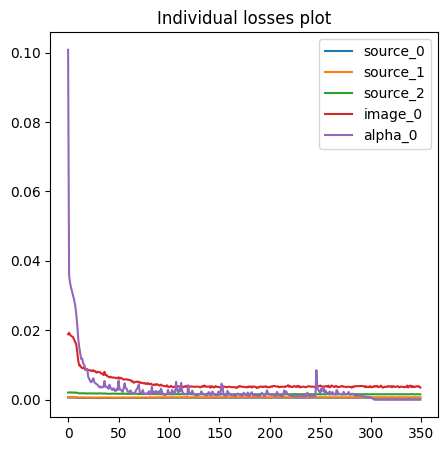

In [11]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

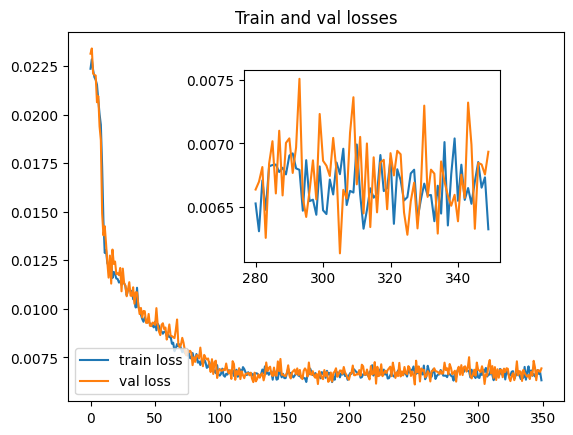

In [12]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['loss'][int(0.8*len(history['loss'])):],label='train loss')
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['val_loss'][int(0.8*len(history['loss'])):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [13]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.006130916310655998


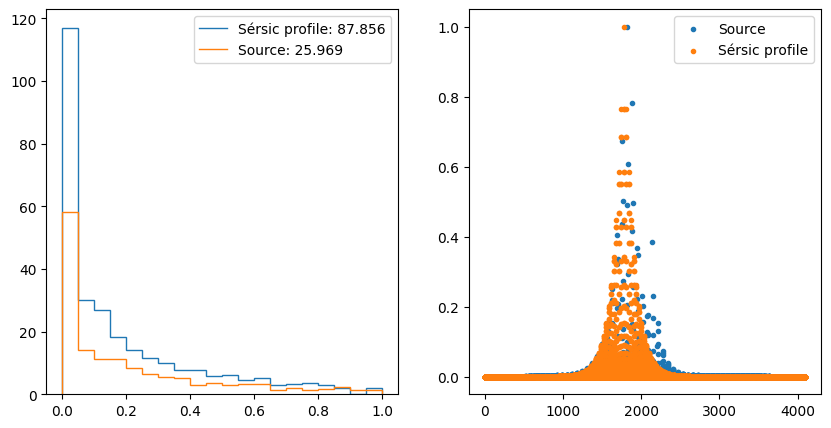

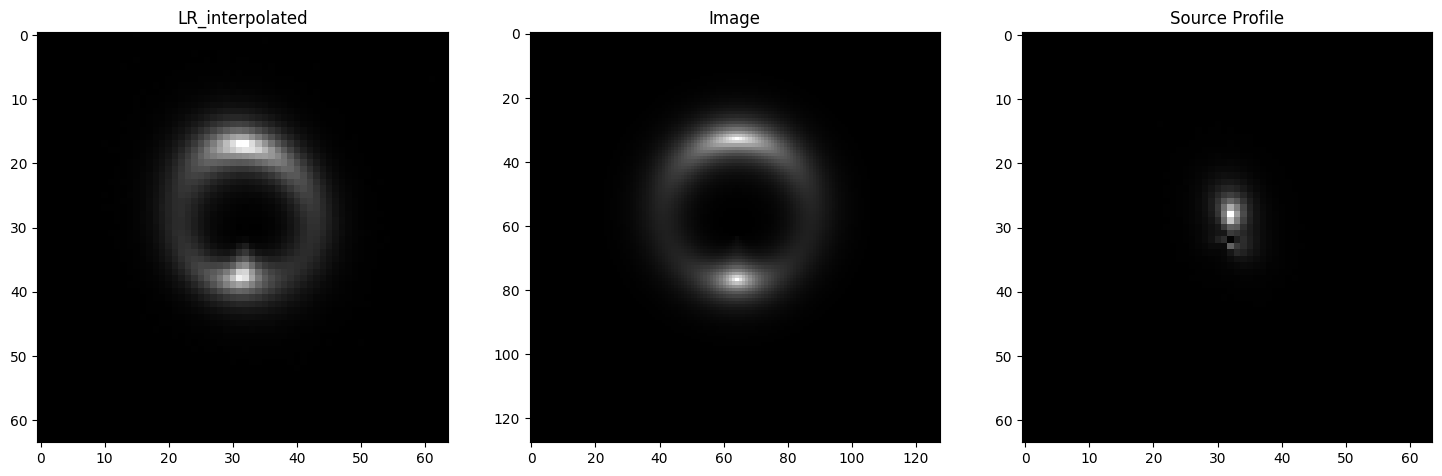

In [14]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [15]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [16]:
torch.save(best_weights, 'Weights_3.pt')